# Foursquare Future Cities Dataset

In [1]:
%matplotlib inline

In [2]:
def import_data(filepath='foursquare/4sqForGoodDataset/', city='London'):
    from pandas import read_csv
    from os.path import join
    venues = read_csv(join(filepath, 'venues_v2', city+'_venue_info_v2.csv'), index_col=0)
    movemt = read_csv(join(filepath, 'movements_v2', city+'_movements_v2.csv'), names=['from', 'to', 'date', 'time', 'num'])
    return venues, movemt

In [3]:
def generate_params(df_v, df_m, by_time=False):
    import numpy as np
    pi = df_v['category'].value_counts()/df_v['category'].count()
    k = len(pi)
    cat_dict = dict(zip(pi.index, range(k)))
    if by_time:
        count = dict()
        for time, df in df_m.groupby('time'):
            count_t = np.zeros((k, k))
            for idx, row in df.iterrows():
                count_t[cat_dict[df_v['category'][row['from']]]][cat_dict[df_v['category'][row['to']]]] += row['num']
            count[time] = count_t            
    else:
        count = np.zeros((k, k))
        for idx, row in df_m.iterrows():
            count[cat_dict[df_v['category'][row['from']]]][cat_dict[df_v['category'][row['to']]]] += row['num']
    return count, pi

In [4]:
def import_all_data(cities=None):
    from numpy import save
    if cities is None: cities = ['Chicago', 'Istanbul', 'Jakarta', 'London', 'Los Angeles', 'New York', 'Paris', 'Seoul', 'Singapore', 'Tokyo']
    for city in cities:
        v, m = import_data(city=city)
        psi, pi = generate_params(v, m)
        save('4sq_'+city+'_psi', psi)
        pi.to_csv('4sq_'+city+'_pi.csv', header=True)

In [5]:
def generate_all_sbms(cities=None):
    from numpy import load
    from pandas import read_csv
    from egosbm import EgocentricSBM
    if cities is None: cities = ['Chicago', 'Istanbul', 'Jakarta', 'London', 'Los Angeles', 'New York', 'Paris', 'Seoul', 'Singapore', 'Tokyo']
    for city in cities:
        psi = load('4sq_'+city+'_psi.npy')
        pi = read_csv('4sq_'+city+'_pi.csv', index_col=0)
        sbm = EgocentricSBM.StochasticBlockModel(psi/psi.sum(), pi=pi.values, name=('4sq_'+city+'_sbm', pi.index), counts=True)
        sbm.save()

In [6]:
def project_all_sbms(m=5, cities=None, plot=False):
    from egosbm import EgocentricSBM
    sbms = dict()
    proj = dict()
    if cities is None: cities = ['Chicago', 'Istanbul', 'Jakarta', 'London', 'Los Angeles', 'New York', 'Paris', 'Seoul', 'Singapore', 'Tokyo']
    for city in cities:
        print(city)
        sbms[city] = EgocentricSBM.StochasticBlockModel(filepath='4sq_'+city+'_sbm.npz')
        proj[city] = sbms[city].project(m=m, plot=plot)
        #proj[city] = sbms[city].eigproj(m=m, plot=plot)
    return sbms, proj

In [7]:
def generate_all_barcodes(cities=None):
    from egosbm import EgocentricSBM
    if cities is None: cities = ['Chicago', 'Istanbul', 'Jakarta', 'London', 'Los Angeles', 'New York', 'Paris', 'Seoul', 'Singapore', 'Tokyo']
    bars = dict()
    for city in cities:
        sbm = EgocentricSBM.StochasticBlockModel(filepath='4sq_'+city+'_sbm.npz')
        bar = sbm.generate_barcode()    
        bar.save()

In [8]:
def get_all_barcodes(cities=None, epsilon=False, plot=False):
    from egosbm import EgocentricSBM
    if cities is None: cities = ['Chicago', 'Istanbul', 'Jakarta', 'London', 'Los Angeles', 'New York', 'Paris', 'Seoul', 'Singapore', 'Tokyo']
    bars = dict()
    for city in cities:
        bar = EgocentricSBM.StochasticBlockModel.Barcode(filepath='4sq_'+city+'_sbm.bar.npz')
        if plot:
            print(city)
            bar.plot(norm=True, log=True)
        bars[city] = bar
    return bars

In [9]:
def get_lividx(cities=None):
    if cities is None: cities = ['Chicago', 'Istanbul', 'Jakarta', 'London', 'Los Angeles', 'New York', 'Paris', 'Seoul', 'Singapore', 'Tokyo']
    from pandas import read_csv
    lividx = read_csv('./foursquare/mercer.csv', index_col='City')
    rank = dict()
    for city in cities:
        if city in lividx.index: rank[city] = lividx['Rank'][city]
        else: rank[city] = None
    return rank        

In [10]:
def get_uas(cities=None):
    if cities is None: cities = ['Chicago', 'Istanbul', 'Jakarta', 'London', 'Los Angeles', 'New York', 'Paris', 'Seoul', 'Singapore', 'Tokyo']
    from pandas import read_csv
    uas_tbl = read_csv('foursquare/matt/uas_20190519.csv', index_col='City')
    nor_tbl = read_csv('foursquare/matt/nor_20190520.csv', index_col='City')
    wtd_tbl = read_csv('foursquare/matt/wtd_20190517.csv', index_col='City')
    spl_tbl = read_csv('foursquare/matt/spatial_20190522.csv', index_col='City')
    uas = {'access':dict(), 'spaho':dict(), 'accesspercat':dict(), 'mean':dict(), 'median':dict(), 'max':dict(), 'meanrelative':dict(), 'medianrelative':dict()}
    wtd = {'degree':dict(), 'edges':dict(), 'clustering':dict()}
    for city in cities:
        if city in uas_tbl.index:
            uas['access'][city] = uas_tbl['Mean Access Stat (100 random venues)'][city]
            uas['mean'][city] = uas_tbl['Mean Trip Distance'][city]
            uas['median'][city] = uas_tbl['Median Trip Dist'][city]
            uas['max'][city] = uas_tbl['Max Trip Dists'][city]
            uas['meanrelative'][city] = uas['mean'][city]/uas['median'][city]
            uas['medianrelative'][city] = uas['median'][city]/uas['max'][city]
        else:
            uas['access'][city] = None
            uas['mean'][city] = None
            uas['median'][city] = None
            uas['max'][city] = None
            uas['relative'][city] = None
        if city in wtd_tbl.index:
            wtd['degree'][city] = wtd_tbl['Mean weighted degree'][city]
            wtd['edges'][city] = wtd_tbl['Number of edges'][city]
            wtd['clustering'][city] = wtd_tbl['Mean Clustering'][city]
        else:
            wtd['degree'][city] = None
            wtd['edges'][city] = None
            wtd['clustering'][city] = None
        if city in nor_tbl.index:            
            uas['accesspercat'][city] = nor_tbl['Venue Mean Degree (Category Normalised)'][city]
        else:
            uas['accesspercat'][city] = None
        if city in spl_tbl.index:            
            uas['spaho'][city] = spl_tbl['Average local availability'][city]
        else:
            uas['spaho'][city] = None
    return uas, wtd

In [11]:
uas, wtd = get_uas()

In [382]:
lividx = get_lividx()
print(lividx)

{'Chicago': 49, 'Istanbul': 130, 'Jakarta': 142, 'London': 41, 'Los Angeles': 66, 'New York': 44, 'Paris': 39, 'Seoul': 77, 'Singapore': 25, 'Tokyo': 49}


In [12]:
def plot_scatter(xdata, ydata, zdata=None, z=0, phi=45, text=None, xlab='x', ylab='y', zlab='z', log=False, dpi=80, ignore=[], save=''):
    import matplotlib.pyplot as plt
    from scipy.stats import spearmanr
    fig = plt.figure(dpi=dpi)
    title = ''
    if isinstance(xdata, dict):
        keys = xdata.keys() - set(ignore)
        ignoring = list(xdata.keys()-keys)
        if ignoring: title = '(ignoring '+', '.join(ignoring)+')'
        xdata = [xdata[key] for key in keys]
        ydata = [ydata[key] for key in keys]
        if zdata is not None: zdata = [zdata[key] for key in keys]
        if text is None: text=list(keys)
    if log:
        from math import log2
        xdata = [log2(x) for x in xdata]
        ydata = [log2(x) for x in ydata]
        if zdata is not None: zdata = [log2(x) for x in zdata]
    if z and zdata is not None:
        from mpl_toolkits.mplot3d import Axes3D
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xdata, ydata, zdata)
        cx = [ax.get_xlim3d()[0]]*len(xdata)
        cy = [ax.get_ylim3d()[0]]*len(ydata)
        cz = [ax.get_zlim3d()[0]]*len(zdata)
        ax.scatter(xdata, ydata, cz, c=zdata, alpha=0.2, lw=0)
        ax.scatter(cx, ydata, zdata, c=xdata, alpha=0.2, lw=0)
        ax.scatter(xdata, cy, zdata, c=ydata, alpha=0.2, lw=0)
        if text is not None: [ax.text(x, y, z, t) for (x,y,z,t) in zip(xdata, ydata, zdata, text)]
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
        ax.set_zlabel(zlab)
        ax.view_init(z, phi)
        rho, pval = spearmanr(xdata, ydata)
        plt.title('rho: %.2f, pval: %.2f %s'%(round(rho,2), round(pval,2), title))
    else:
        plt.scatter(xdata, ydata, c=zdata)
        if text is not None: [plt.text(x, y, t) for (x,y,t) in zip(xdata, ydata, text)]
        rho, pval = spearmanr(xdata, ydata)
        plt.title('rho: %.2f, pval: %.2f %s'%(round(rho,2), round(pval,2), title))
        if zdata is not None:
            cbar = plt.colorbar()
            cbar.set_label(zlab)
        plt.xlabel(xlab)
        plt.ylabel(ylab)
    if save: plt.savefig(save+'/'+xlab+'_'+ylab+'.png')
    else: plt.show()
    return rho, pval

In [13]:
def pw(dict_of_dicts, dict_of_dicts_2=None, ignore=[]):
    if not isinstance(dict_of_dicts, dict): dict_of_dicts = dict(zip(range(1, len(dict_of_dicts)+1), dict_of_dicts))
    if dict_of_dicts_2 is None: dict_of_dicts_2 = dict_of_dicts.copy()
    keys = list(dict_of_dicts.keys())
    keys_2 = list(dict_of_dicts_2.keys())
    corr = list()
    for i in keys:
        for j in keys_2:
            rho, pval = plot_scatter(dict_of_dicts[i], dict_of_dicts_2[j], xlab=i, ylab=j, ignore=ignore, save='./foursquare/figs')
            corr.append((i, j, rho, pval))
    corr = sorted(corr, key=lambda x: abs(x[2]))[::-1]
    order = list()
    order_2 = list()
    for c in corr:
        if c[0]==c[1]: continue
        if c[0] not in order:
            order.append(c[0])
            if c[0] in keys_2 and c[0] not in order_2: order_2.append(c[0])
        if c[1] not in order_2:
            order_2.append(c[1])
            if c[1] in keys and c[1] not in order: order.append(c[1])
    order = dict(zip(order, range(len(order))))
    order_2 = dict(zip(order_2, range(len(order_2))))
    import numpy as np
    corrs = np.zeros((len(order), len(order_2)))
    pvals = np.zeros((len(order), len(order_2)))
    for c in corr:
        corrs[order[c[0]]][order_2[c[1]]] = c[2]
        pvals[order[c[0]]][order_2[c[1]]] = c[3]
    from pandas import DataFrame
    return DataFrame(corrs, index=order.keys(), columns=order_2.keys()), DataFrame(pvals, index=order.keys(), columns=order_2.keys())

In [14]:
def plot_dists(dist_dict, xlab='', dpi=80):
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(dpi=dpi)
    if not isinstance(dist_dict, dict): dist_dict = {'var':dist_dict}
    for key in dist_dict: sns.distplot(dist_dict[key], label=key, hist=False)
    if xlab: plt.xlabel(xlab)
    plt.legend()
    plt.show()

In [15]:
def plot_lines(line_dict, xlab='', ylab='', markers=dict(), var='', marker_name='', dpi=80):
    import matplotlib.pyplot as plt
    plt.figure(dpi=dpi)
    if any([not isinstance(i, dict) for i in line_dict.values()]): line_dict = {var:line_dict}
    else:
        if var:
            if isinstance(var, str): line_dict = {var:line_dict[var]}
            else: line_dict = {v:line_dict[v] for v in var}
    if not isinstance(markers, dict): markers = {var:markers}
    else:
        if var:
            if isinstance(var, str): markers = {var:markers[var]}
            else: markers = {v:markers[v] for v in var}
    handles = list()
    for key in line_dict: handles.append(plt.plot(line_dict[key]['x'], line_dict[key]['y'], label=key))
    if markers:
        for key in markers:
            for i in markers[key]:
                h = plt.scatter(line_dict[key]['x'][i], line_dict[key]['y'][i], color='black', marker='x', label=marker_name)
    if xlab: plt.xlabel(xlab)
    if ylab: plt.ylabel(ylab)
    handles = [h[0] for h in handles]
    if marker_name: handles.append(h)
    plt.legend(handles=handles)
    plt.show()

In [16]:
#import_all_data()
#generate_all_sbms()
#generate_all_barcodes()

In [17]:
sbms, projs = project_all_sbms()

Chicago


C:\Users\sl2416\Documents\phd\dat\egosbm.py:1168: RuntimeWarning: symmetrising the stochastic block matrix
  if self.directed: warn('symmetrising the stochastic block matrix', RuntimeWarning)
C:\Users\sl2416\Documents\phd\dat\egosbm.py:1026: RuntimeWarning: assuming given matrix is a block matrix; if otherwise use counts=True
  warn('assuming given matrix is a block matrix; if otherwise use counts=True', RuntimeWarning)


Istanbul
Jakarta
London
Los Angeles
New York
Paris
Seoul
Singapore
Tokyo


In [18]:
num = {key: len(sbms[key]) for key in sbms}
dev = {key: sum(sbms[key].get_pi()**2) for key in sbms}
spaho = {key: uas['accesspercat'][key]/uas['access'][key]for key in num}

In [19]:
sas = dict()
sas_lr = dict()
from math import log2
for city in projs.keys():
    sas[city] = sbms[city].sas_global(log=False, ratio=False)
    sas_lr[city] = projs[city].sas_global(log=True, ratio=True)
sas_mean, sas_var = {key: sas[key][0] for key in sas}, {key: sas[key][1] for key in sas}
sas_lr_mean, sas_lr_var = {key: sas_lr[key][0] for key in sas_lr}, {key: sas_lr[key][1] for key in sas_lr}

In [20]:
print(sas)
print(sas_lr)

{'Chicago': (-1.0, 2.6098687885356924), 'Istanbul': (-1.0, 6.9231950792209), 'Jakarta': (-1.0, 2.6401458827268947), 'London': (-1.0, 1.9980864615030158), 'Los Angeles': (-1.0, 1.519500475163398), 'New York': (-1.0, 4.269534368505364), 'Paris': (-1.0, 4.169077262150283), 'Seoul': (-1.0, 2.794639901018822), 'Singapore': (-1.0, 3.7700864554438), 'Tokyo': (-1.0000000000000002, 6.625869362241224)}
{'Chicago': (0.7935985505914955, 3.118497190309786), 'Istanbul': (0.5355631702220832, 0.6531387567303638), 'Jakarta': (0.07856958390407663, 0.3575828974780946), 'London': (0.5574703087512413, 1.5417317142383606), 'Los Angeles': (0.6137616176691043, 0.7407857684844856), 'New York': (0.5317817581791149, 0.8494562161906063), 'Paris': (0.3770175881538457, 0.5558379760855114), 'Seoul': (0.07324282602778939, 0.5566839065213348), 'Singapore': (0.3436452401707707, 0.8572034540082764), 'Tokyo': (0.34877917518728124, 1.070467270715074)}


In [21]:
bars = get_all_barcodes()

In [22]:
eps = {key: -bars[key].get_epsilon(log=True, norm=False) for key in bars}

In [23]:
events = {key: [i for i in range(len(bars[key])) if any([bars[key].dims[x[0]]=='Metro Stations' or bars[key].dims[x[1]]=='Metro Stations' for x in bars[key].event[i]])] for key in bars}

In [24]:
len(events['Chicago'])

377

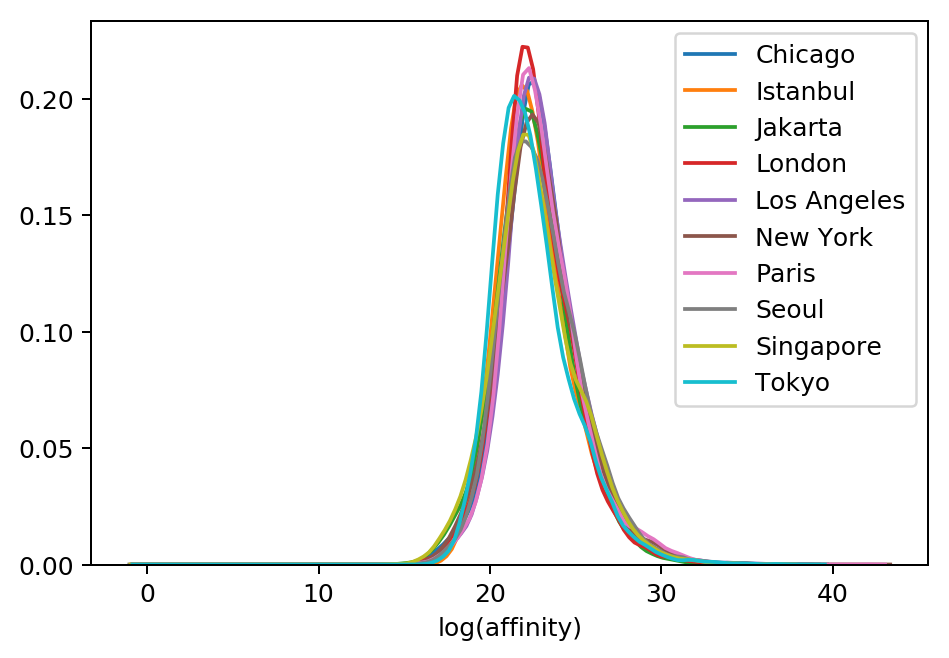

In [25]:
plot_dists(eps, 'log(affinity)', dpi=180)

In [26]:
betti0_curves = {key: {'x':bars[key].get_epsilon(log=True, norm=True), 'y':bars[key].get_betti(0, norm=True)} for key in bars}
betti1_curves = {key: {'x':bars[key].get_epsilon(log=True, norm=True), 'y':bars[key].get_betti(1, norm=True)} for key in bars}

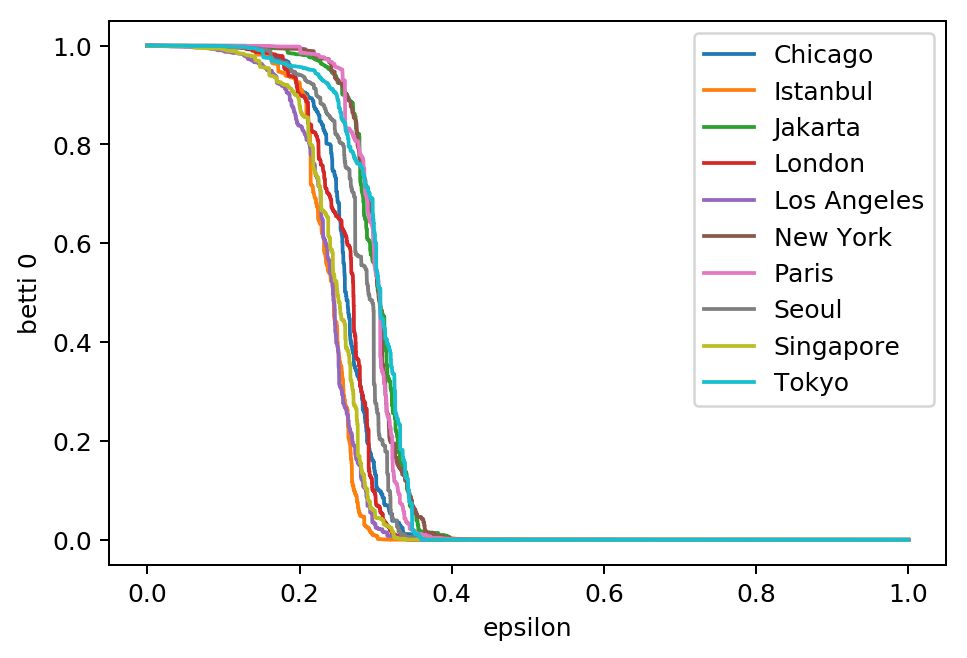

In [27]:
plot_lines(betti0_curves, 'epsilon', 'betti 0', dpi=180)

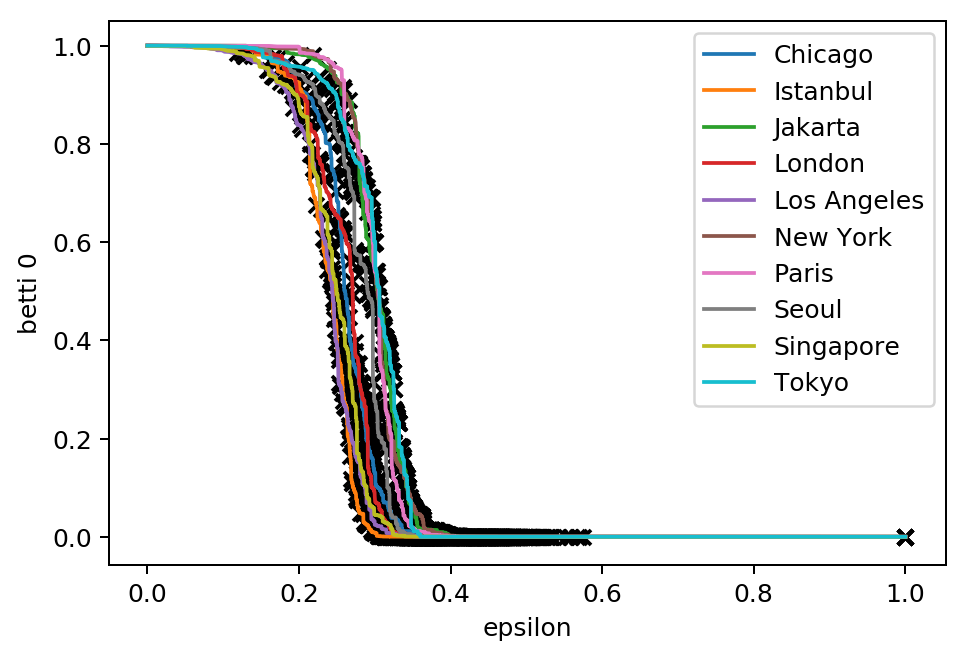

In [28]:
plot_lines(betti0_curves, 'epsilon', 'betti 0', markers=events, dpi=180)

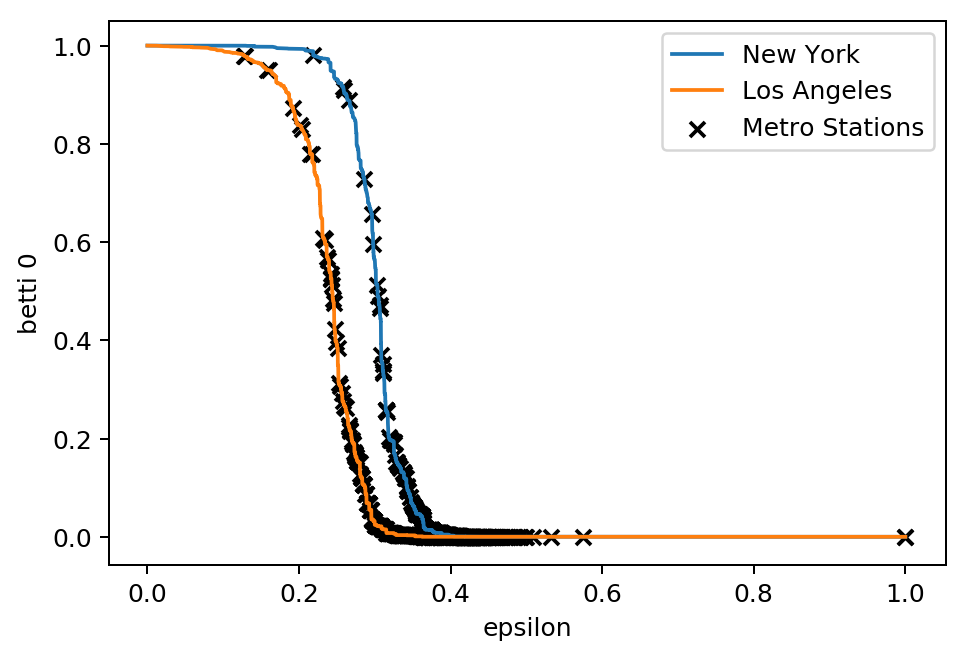

In [29]:
plot_lines(betti0_curves, 'epsilon', 'betti 0', markers=events, marker_name='Metro Stations',var=['New York','Los Angeles'], dpi=180)

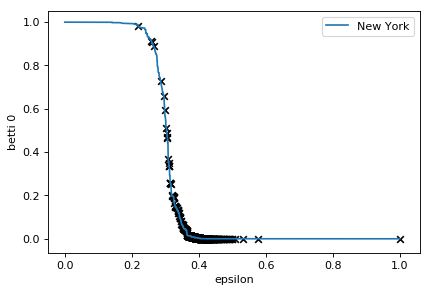

In [30]:
plot_lines(betti0_curves, 'epsilon', 'betti 0', markers=events, var='New York')

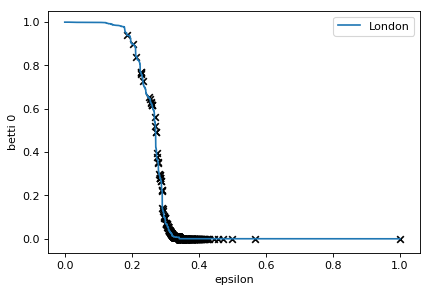

In [31]:
plot_lines(betti0_curves, 'epsilon', 'betti 0', markers=events, var='London')

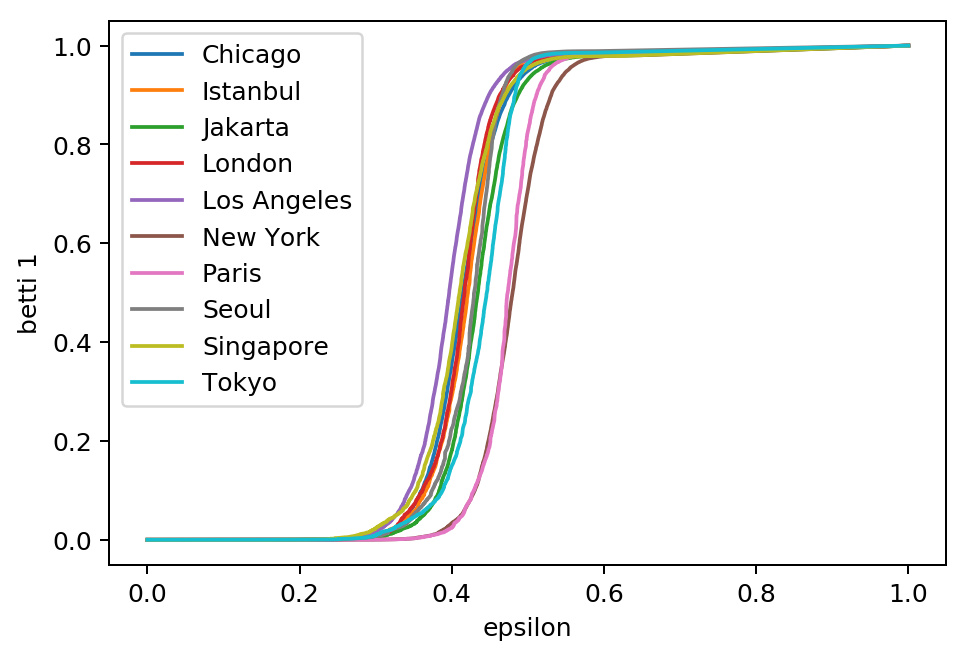

In [32]:
plot_lines(betti1_curves, 'epsilon', 'betti 1', dpi=180)

In [33]:
betti = {key: bars[key].area(log=True) for key in bars}
betti_0, betti_1 = {key: betti[key][0] for key in betti}, {key: betti[key][1] for key in betti}
print(betti)

{'Chicago': (0.2607106296675886, 0.5782382611265171), 'Istanbul': (0.23763200710614943, 0.5773955056305528), 'Jakarta': (0.3006018558690719, 0.5599668306141472), 'London': (0.2580461401290815, 0.5797830921431288), 'Los Angeles': (0.23733602683161634, 0.5980429243223676), 'New York': (0.30097219886361304, 0.5151619824014884), 'Paris': (0.2978476364395931, 0.5231293262356128), 'Seoul': (0.27829878324865776, 0.5721692161780946), 'Singapore': (0.24401003608993563, 0.5835349232516903), 'Tokyo': (0.29780081947715276, 0.5571406246944799)}


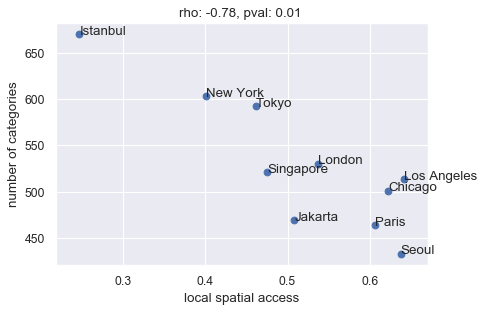

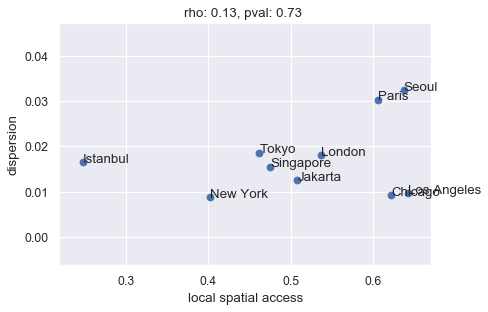

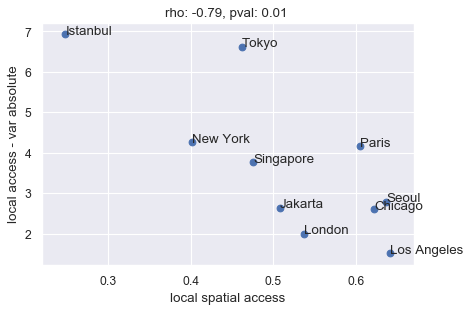

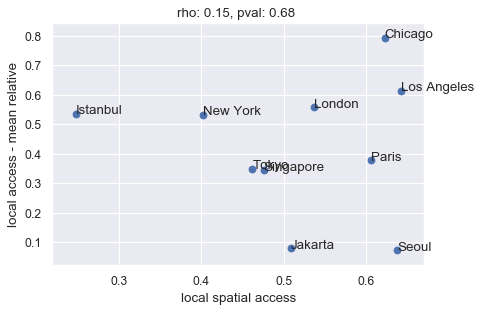

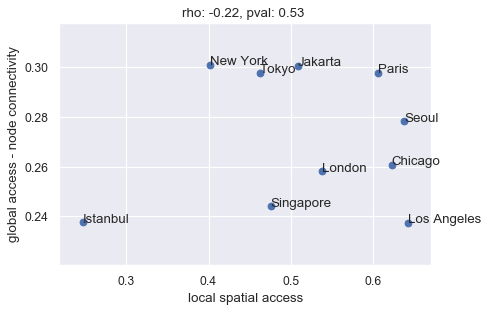

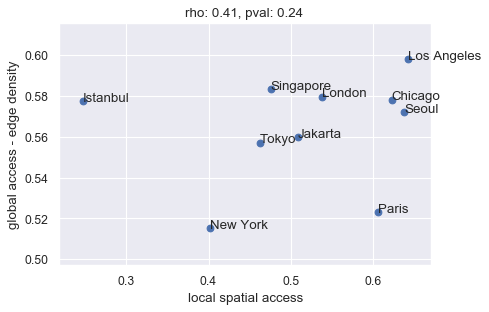

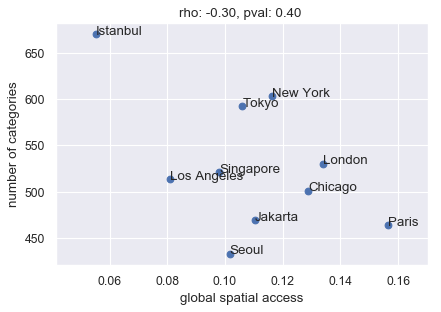

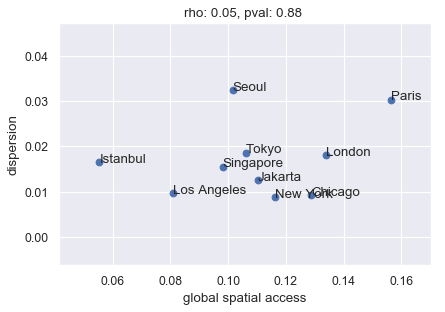

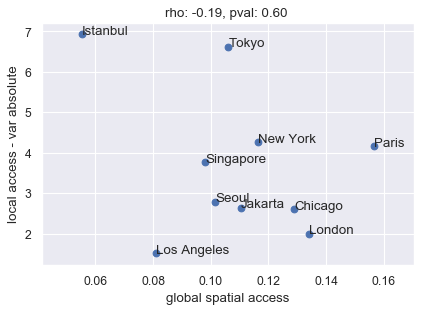

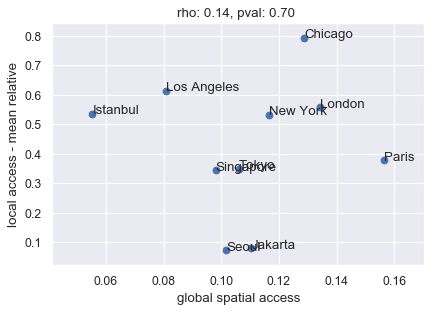

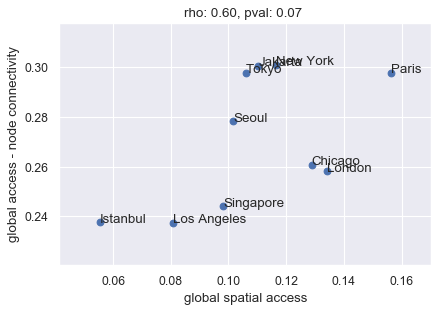

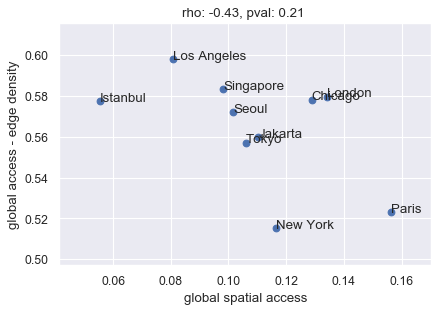

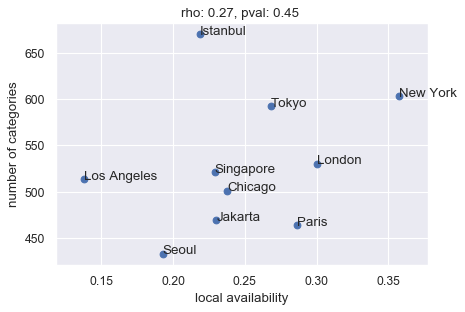

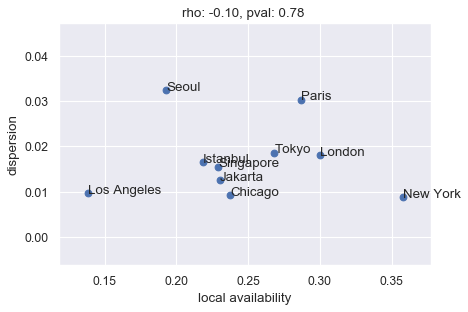

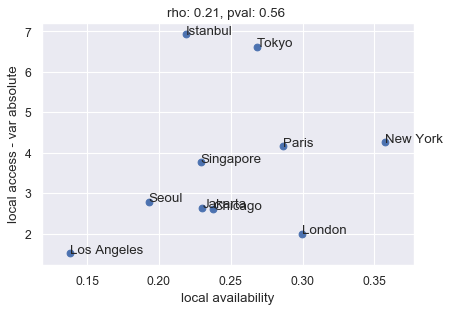

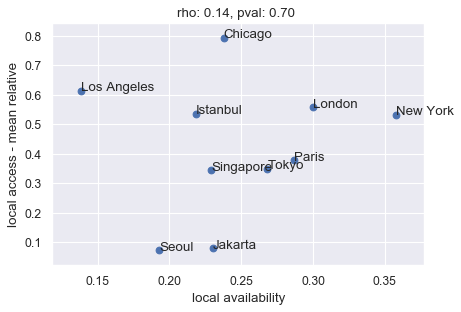

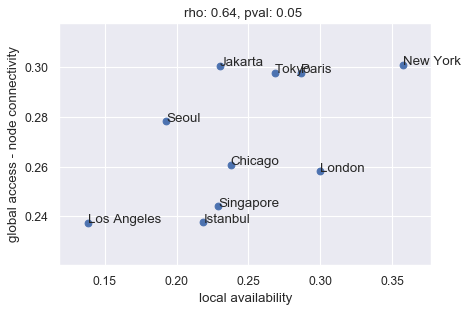

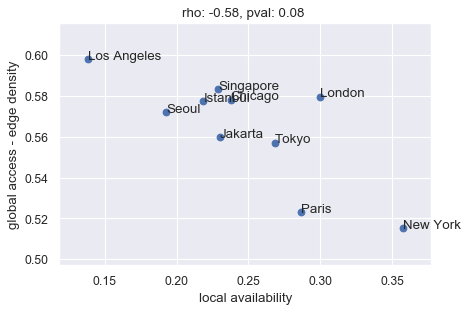

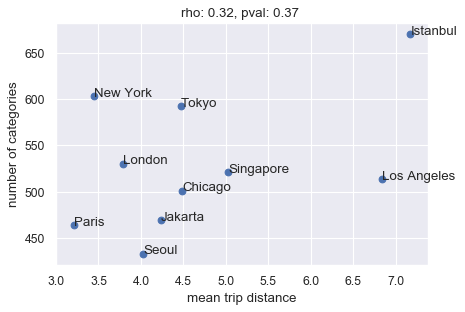

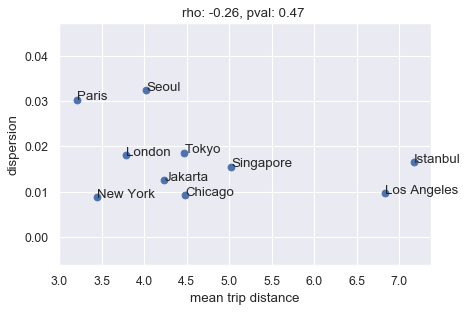

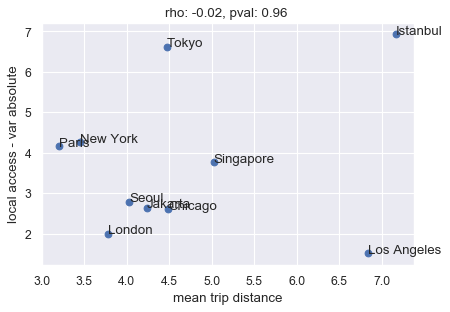

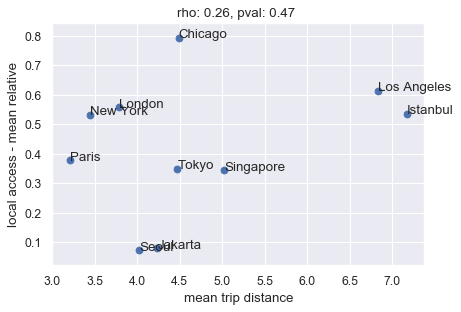

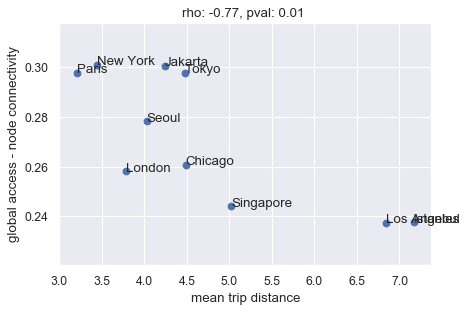

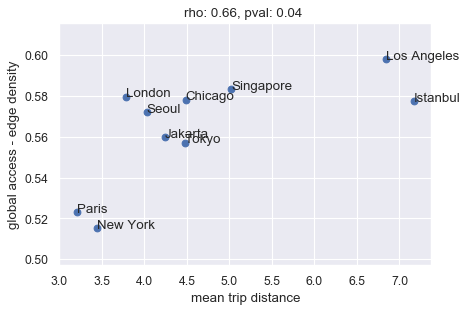

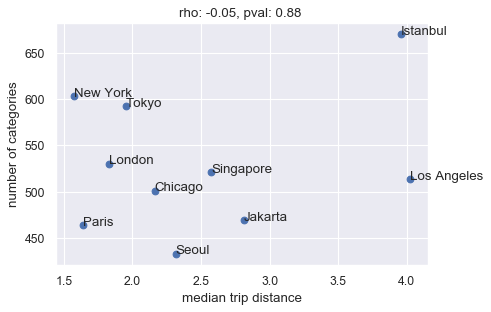

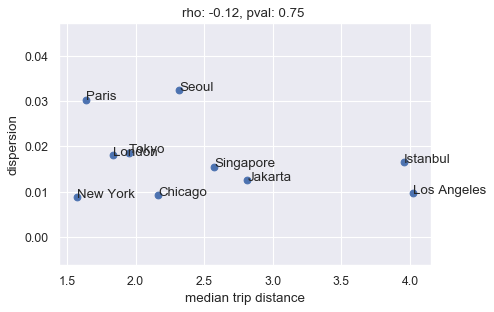

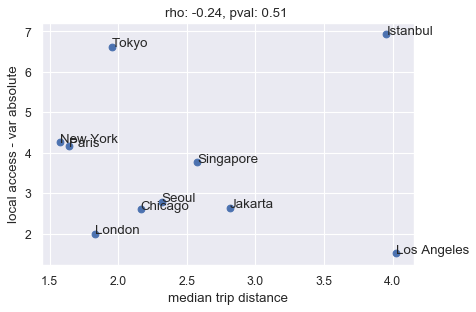

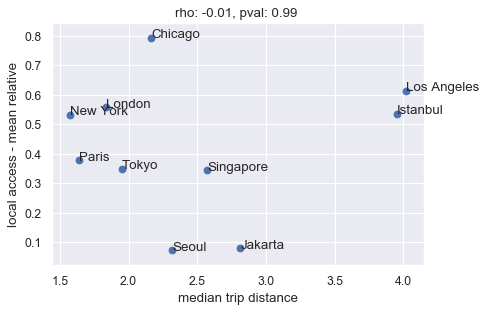

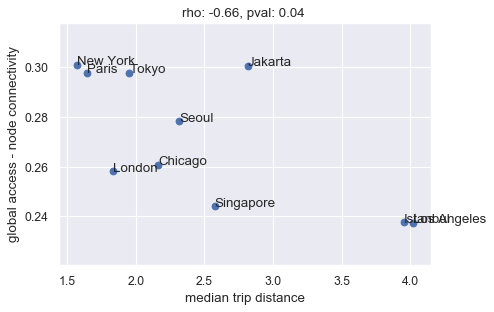

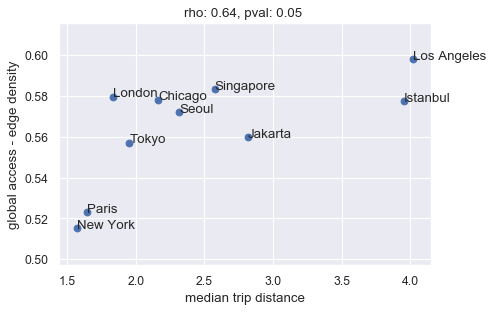

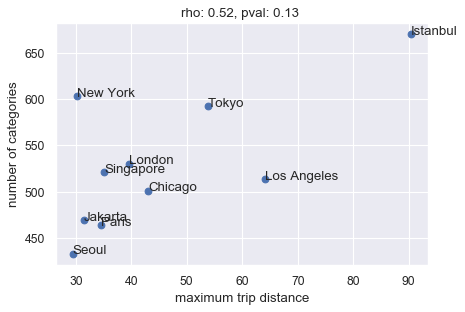

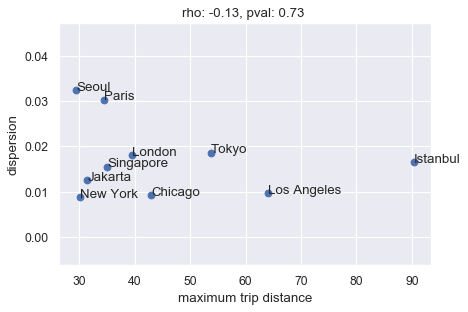

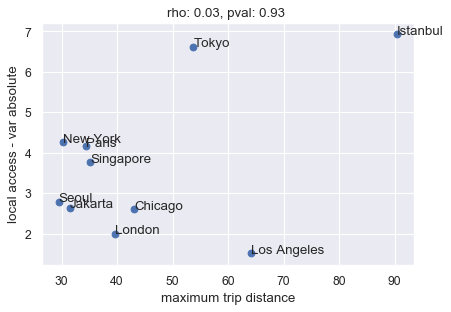

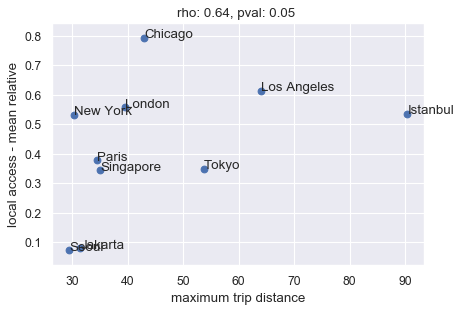

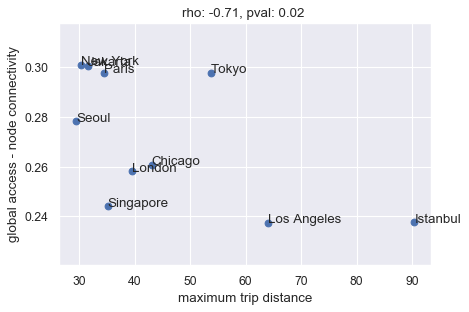

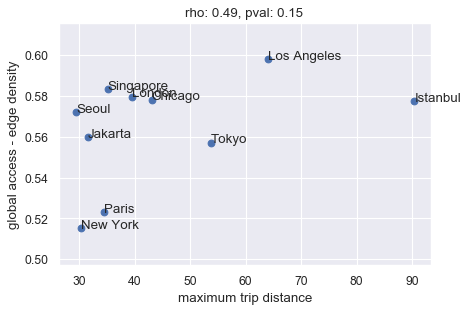

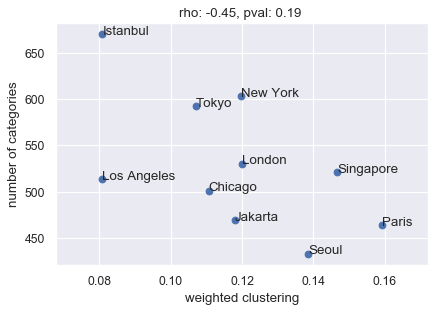

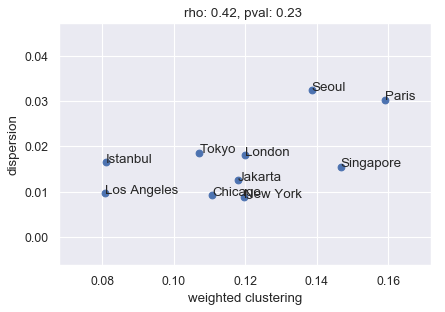

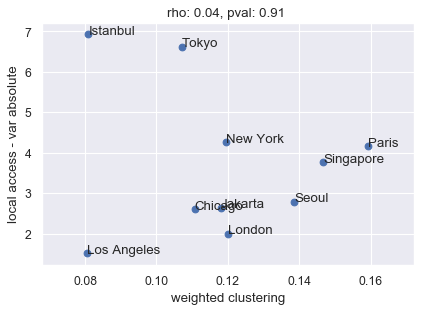

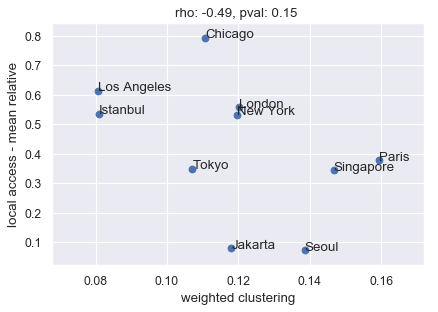

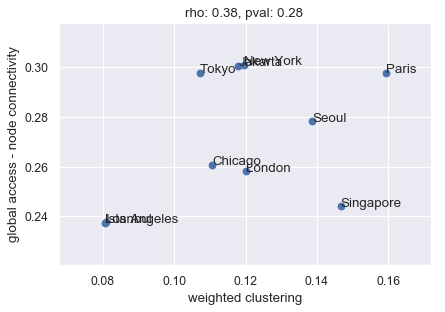

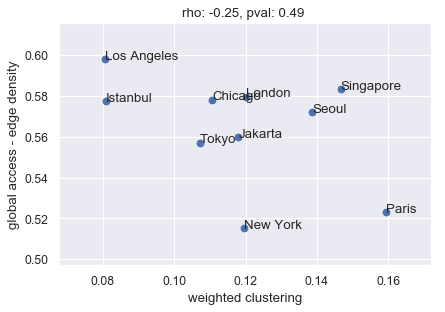

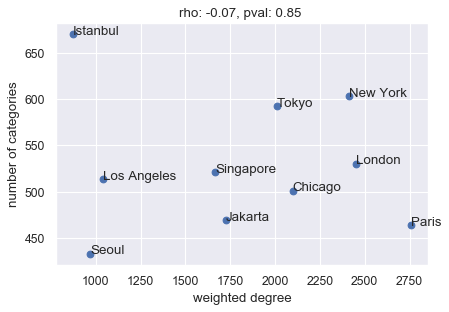

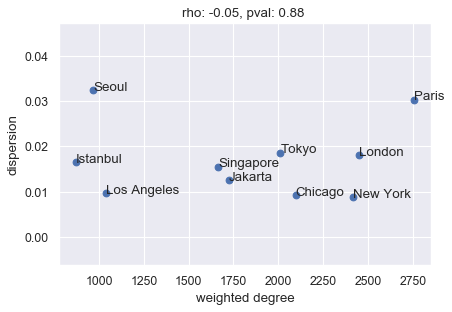

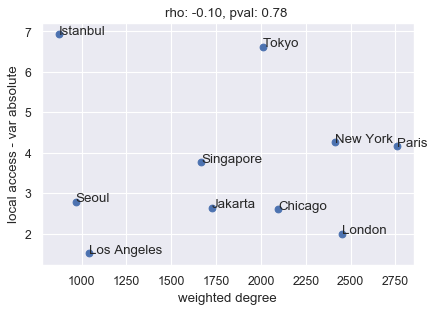

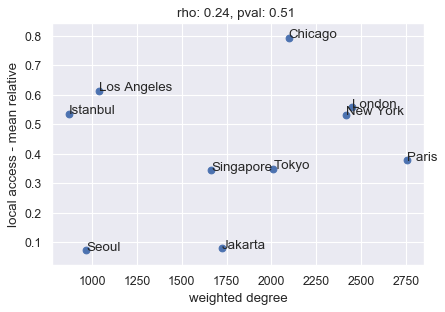

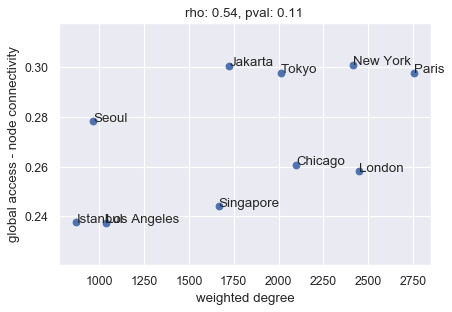

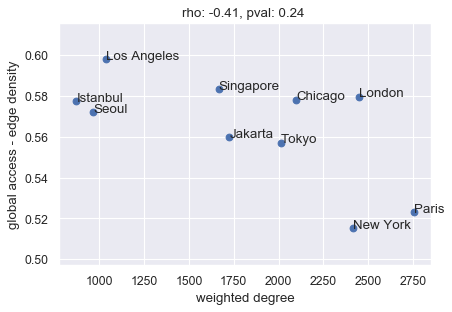

In [577]:
corrs = pw({'local spatial access':uas['access'],
            'global spatial access':uas['accesspercat'],
            'local availability':uas['spaho'],
            'mean trip distance':uas['mean'],
            'median trip distance':uas['median'],
            'maximum trip distance':uas['max'],
            'weighted clustering':wtd['clustering'],
            'weighted degree':wtd['degree']},
           {'number of categories':num,
            'dispersion':dev,
            'local access - var absolute':sas_var, 
            'local access - mean relative':sas_lr_mean,
            'global access - node connectivity':betti_0, 
            'global access - edge density':betti_1})

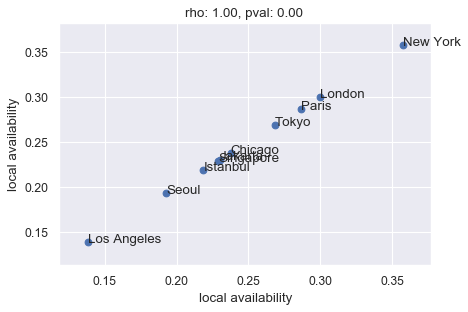

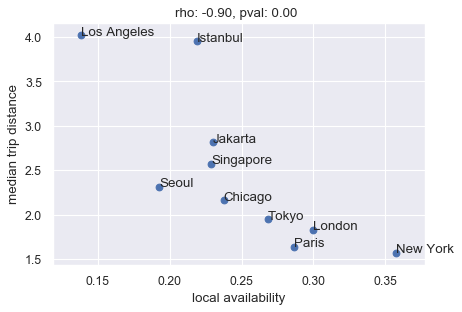

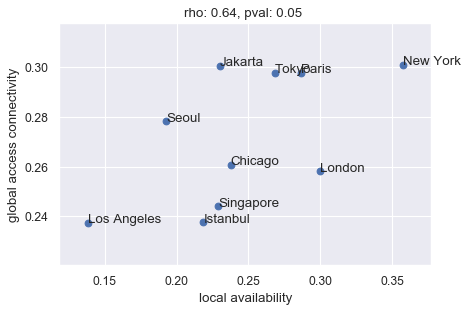

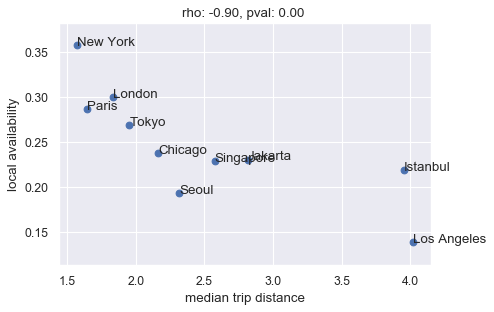

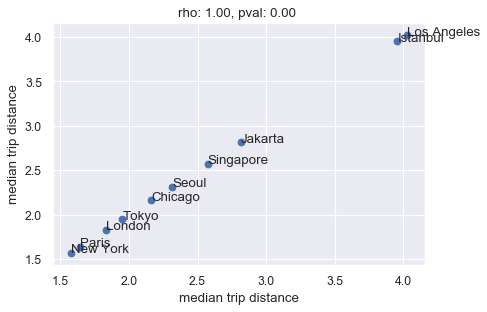

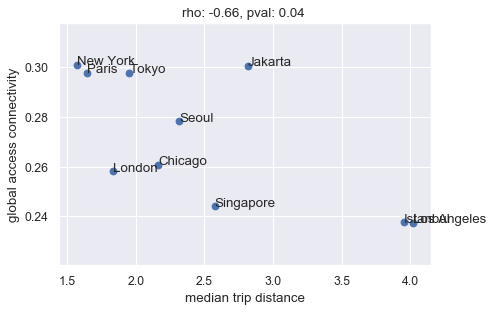

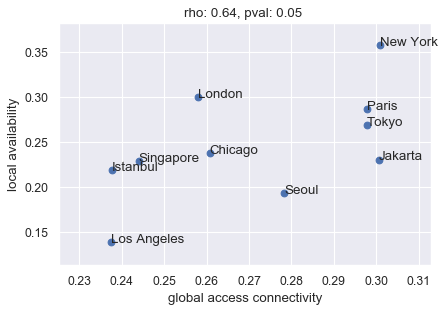

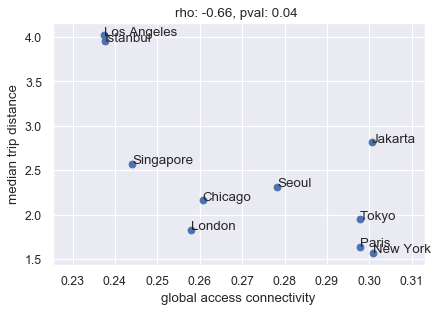

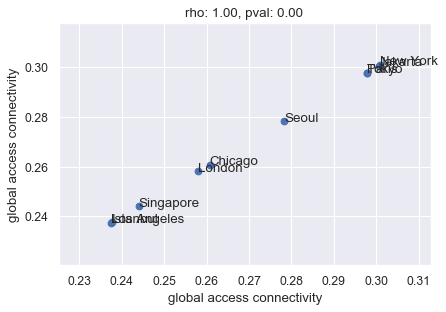

In [37]:
corrs_int = pw({
            'local availability':uas['spaho'],
            'median trip distance':uas['median'],
            'global access connectivity':betti_0})

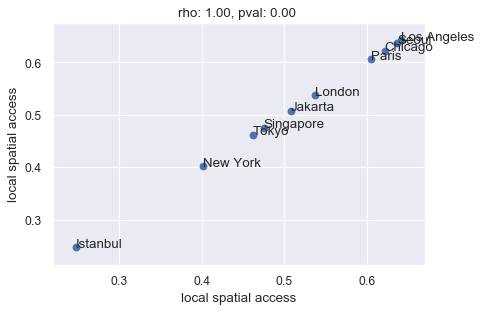

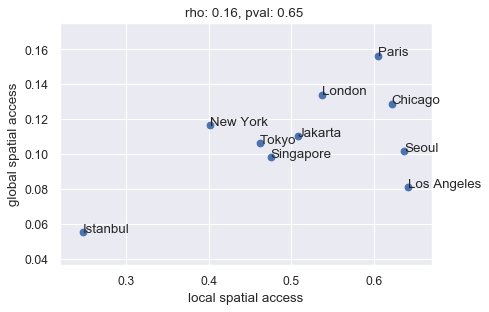

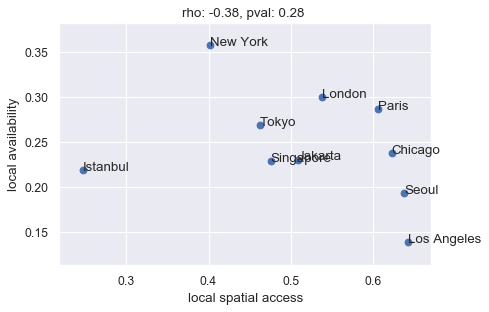

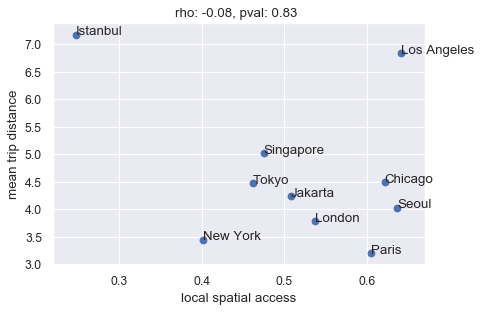

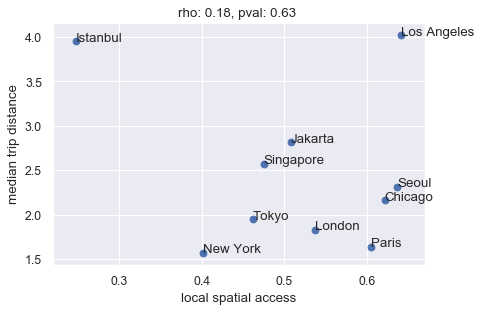

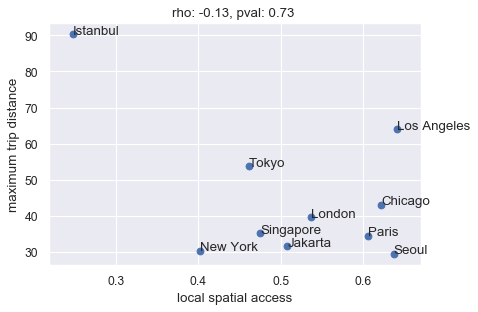

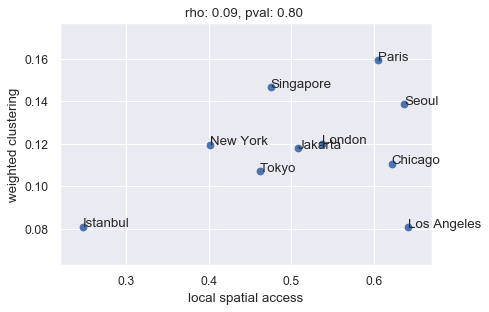

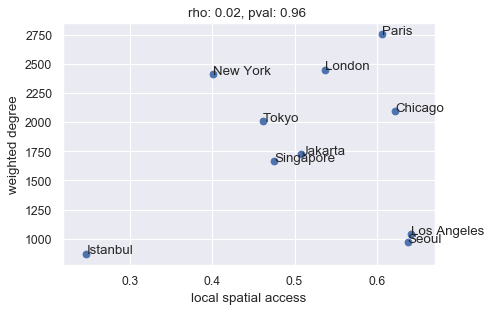

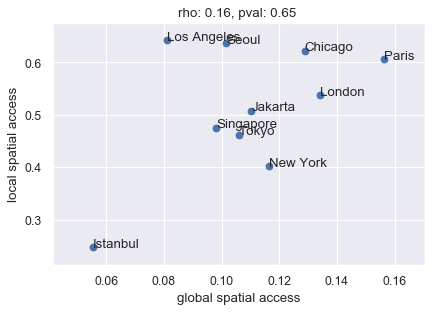

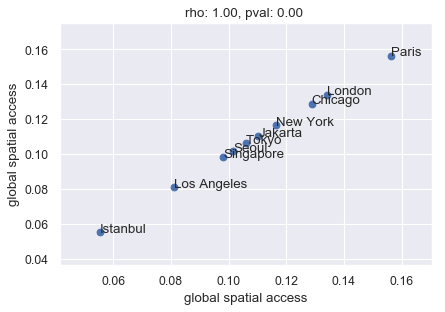

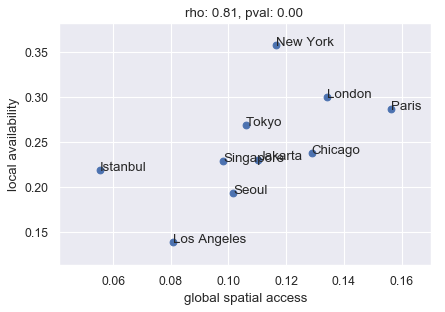

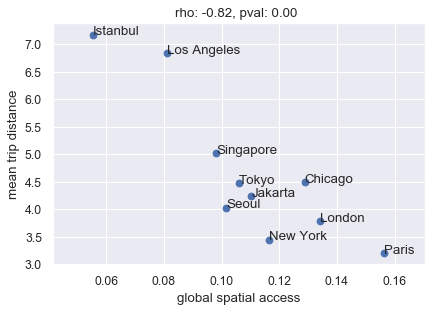

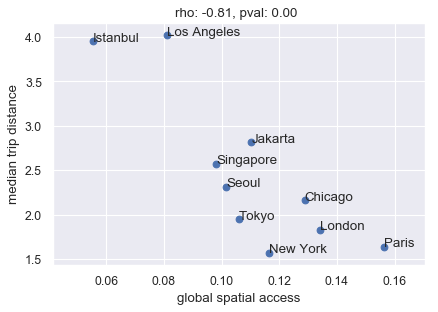

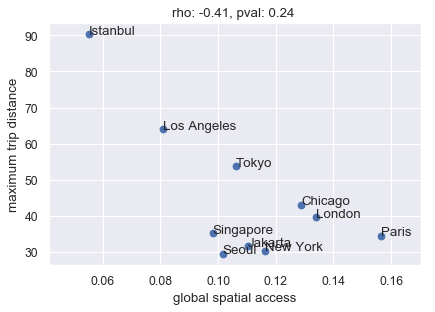

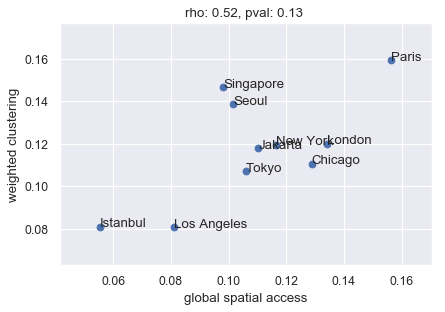

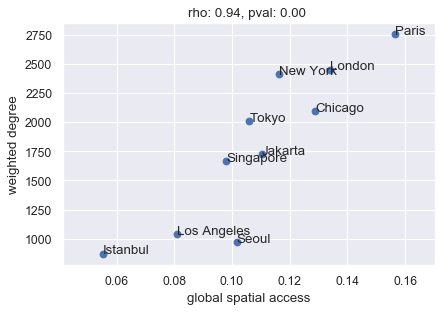

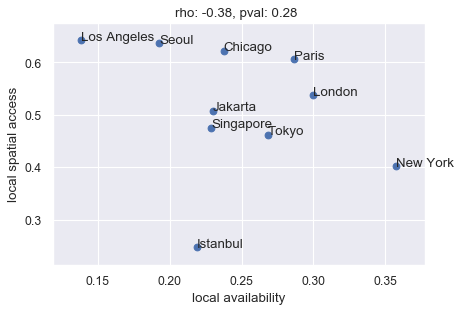

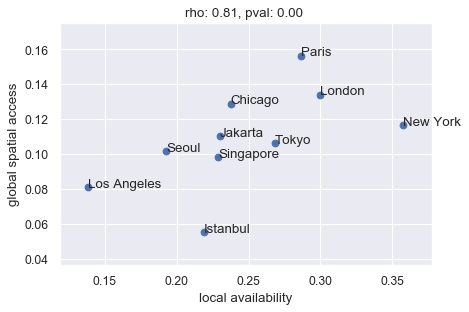

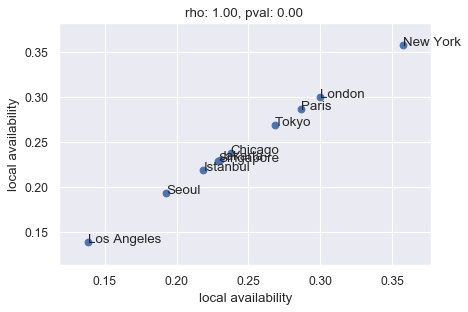

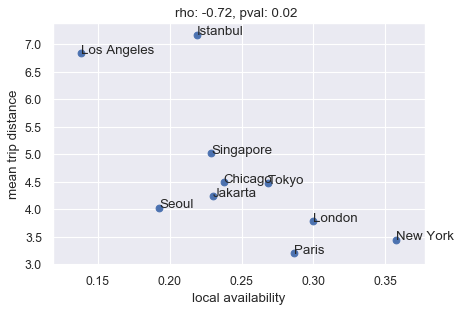

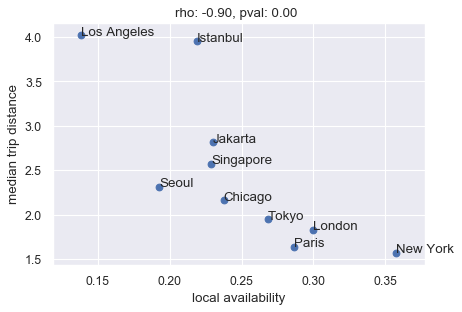

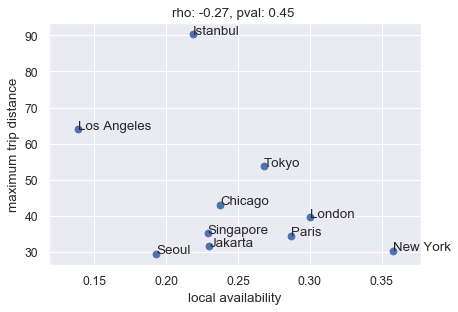

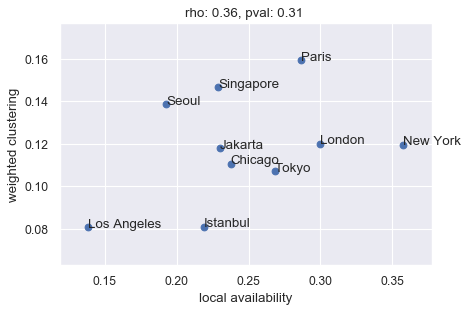

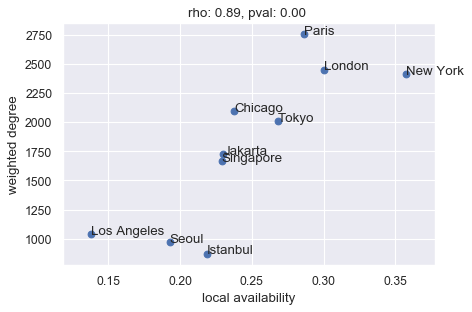

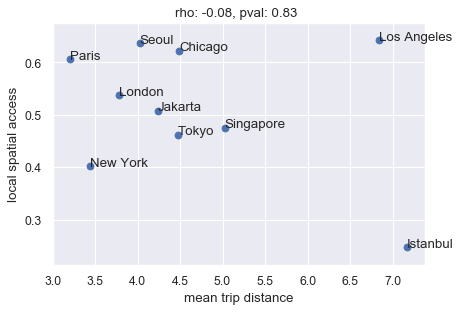

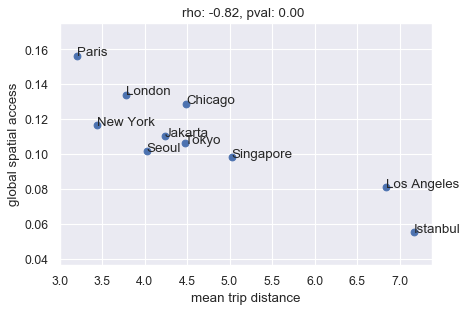

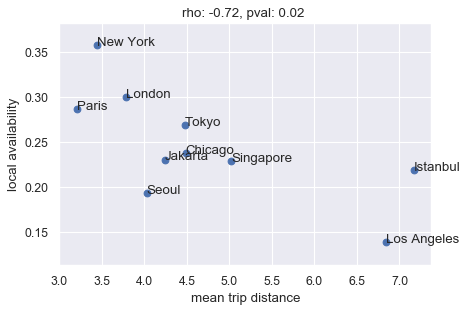

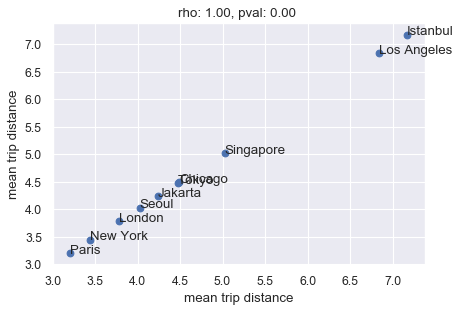

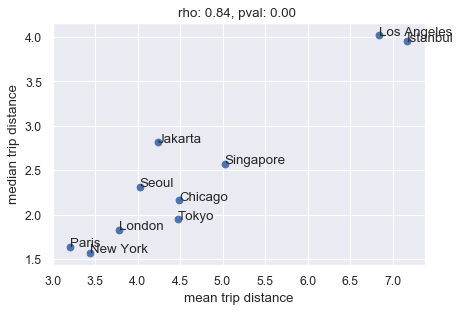

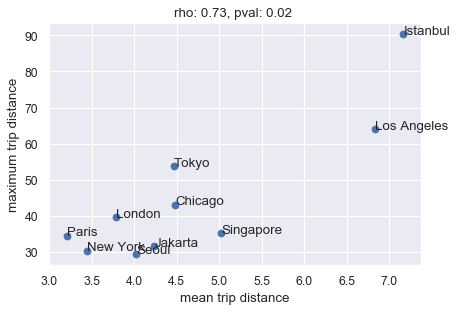

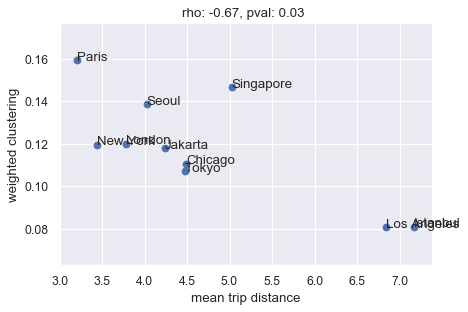

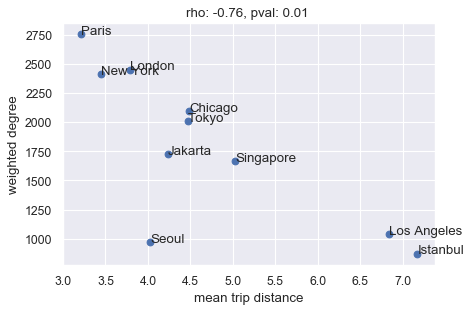

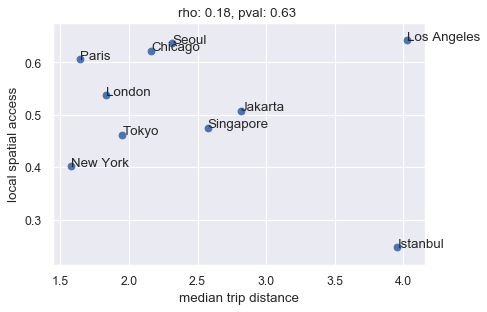

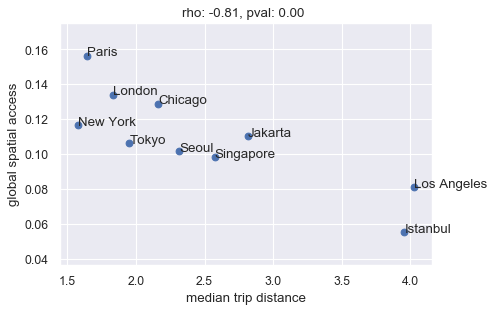

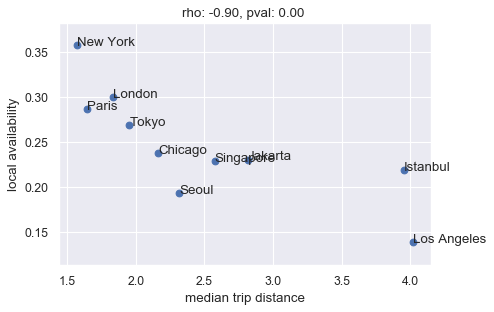

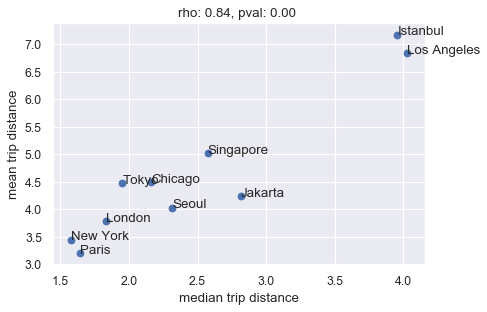

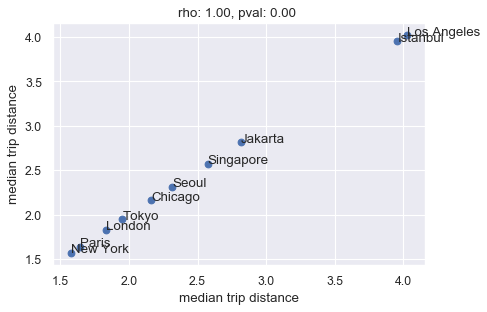

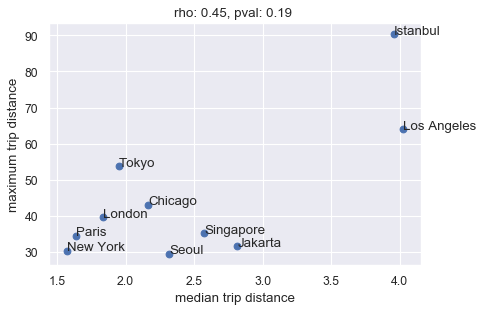

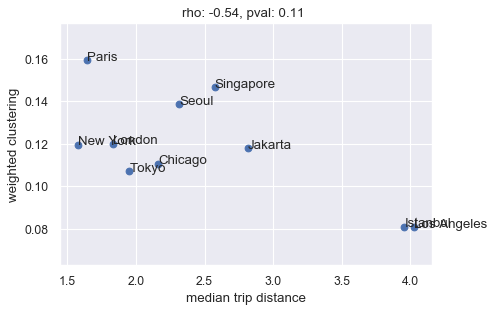

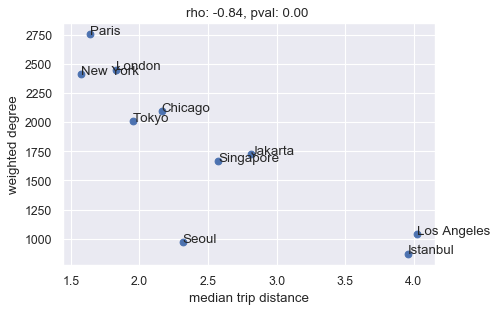

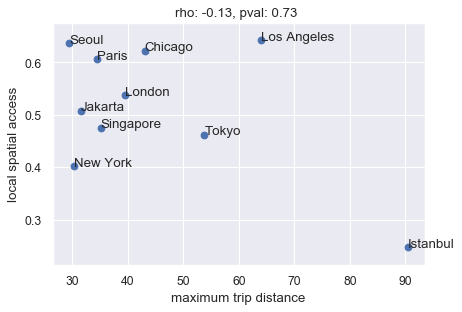

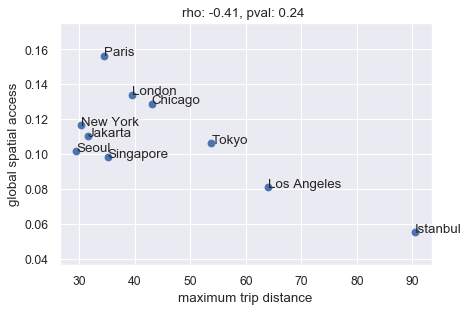

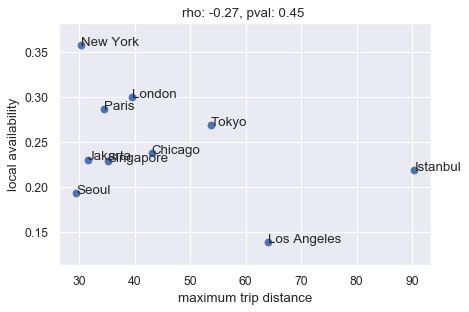

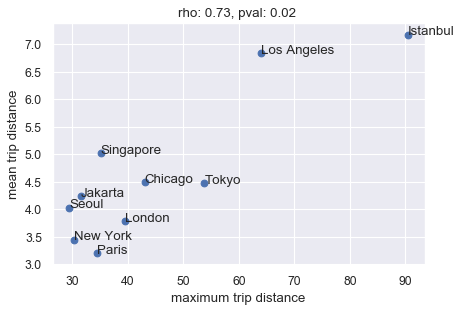

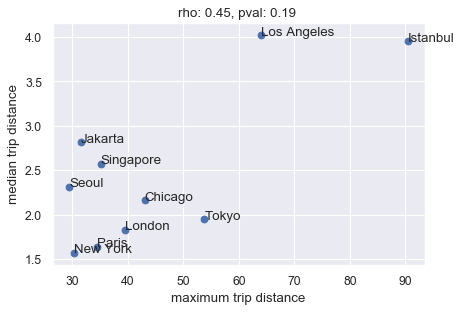

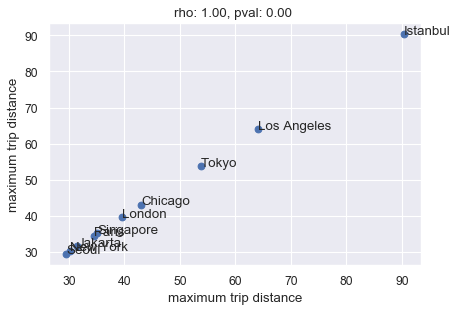

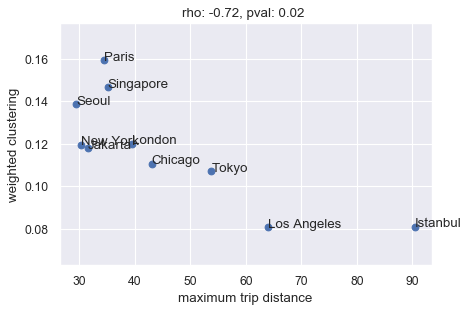

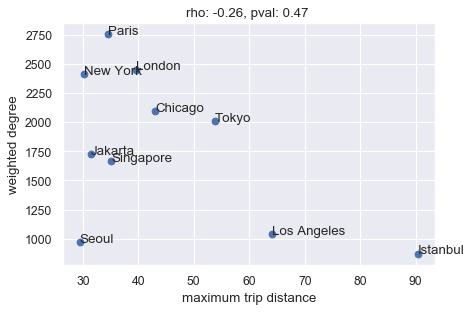

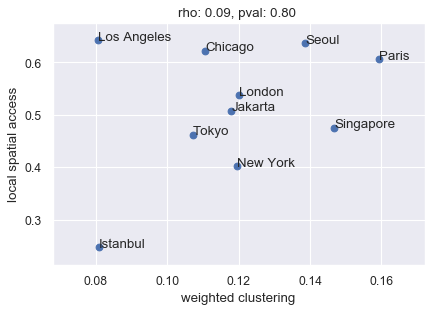

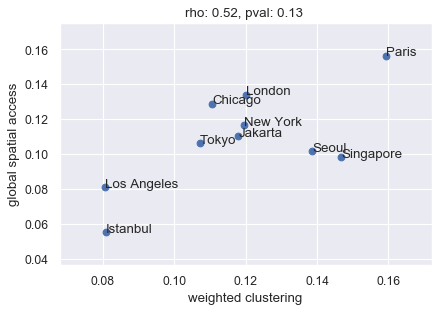

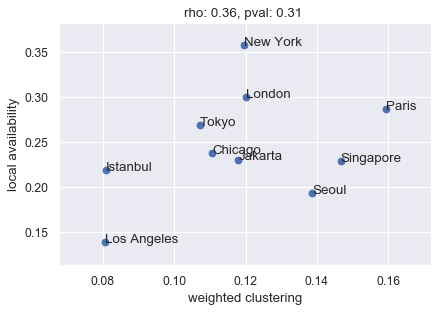

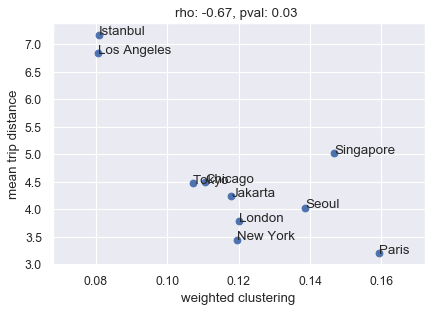

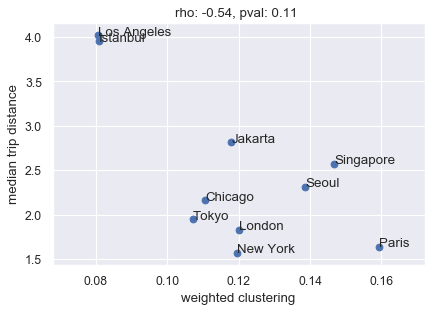

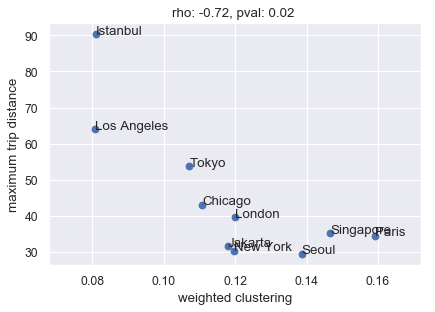

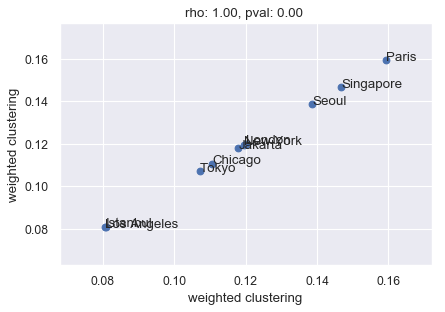

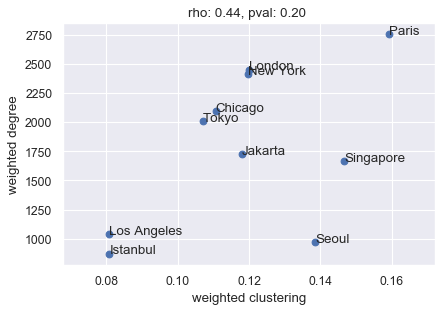

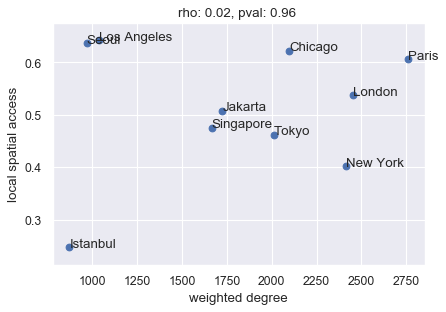

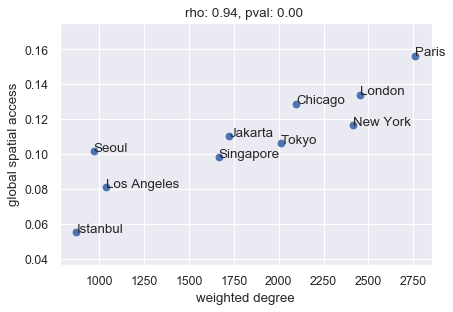

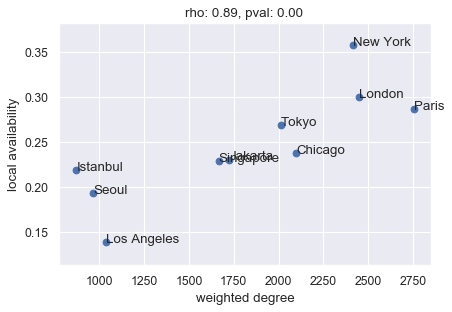

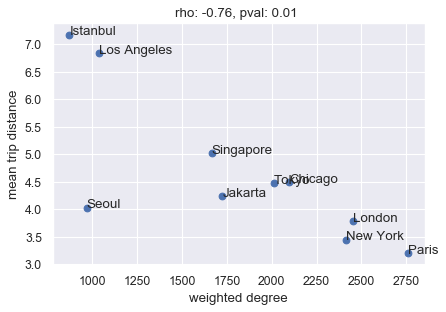

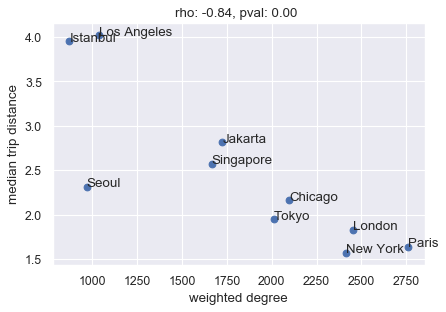

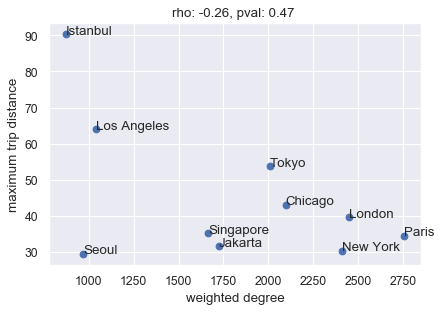

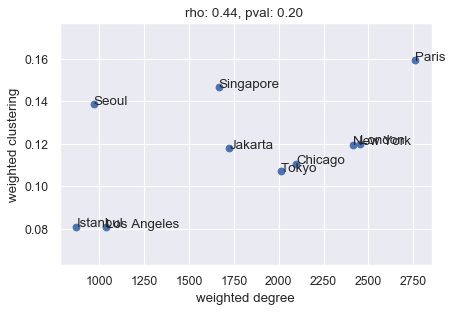

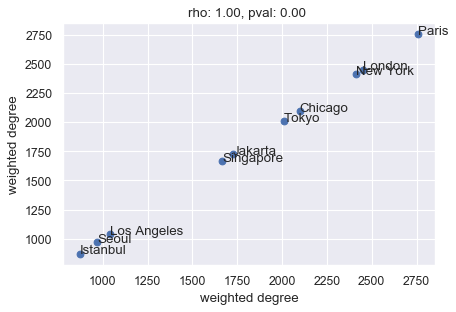

In [578]:
corrs_spatial = pw({'local spatial access':uas['access'],
                    'global spatial access':uas['accesspercat'],
            'local availability':uas['spaho'],
            'mean trip distance':uas['mean'],
            'median trip distance':uas['median'],
            'maximum trip distance':uas['max'],
            'weighted clustering':wtd['clustering'],
            'weighted degree':wtd['degree']})

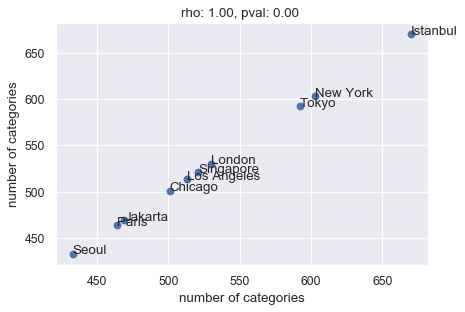

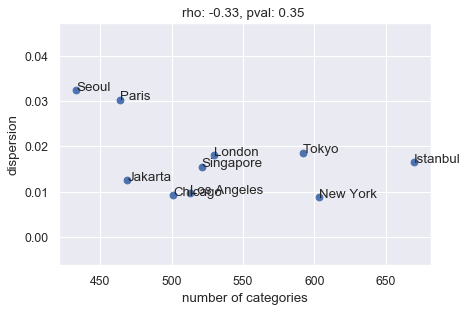

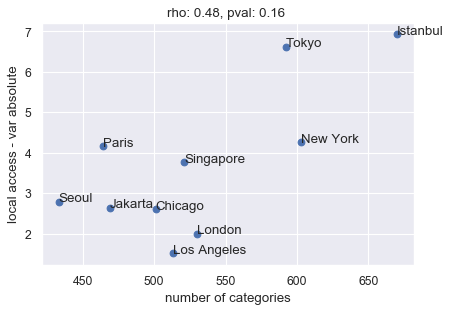

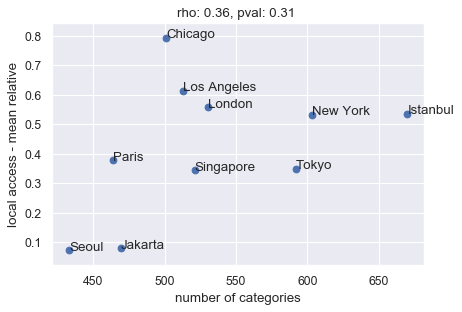

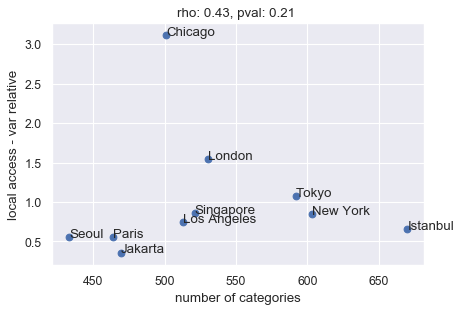

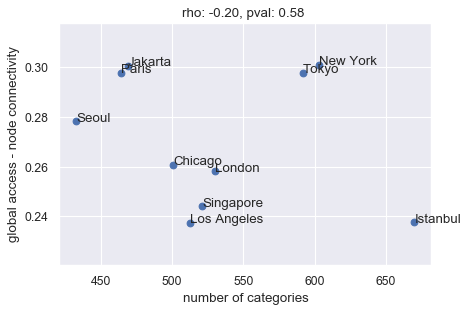

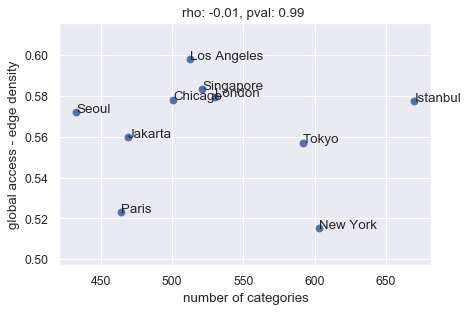

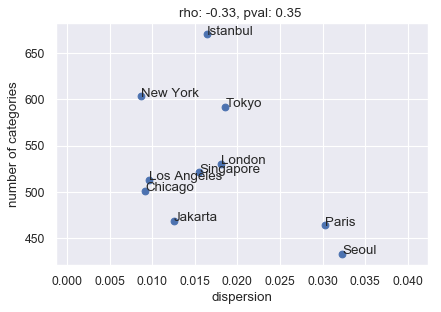

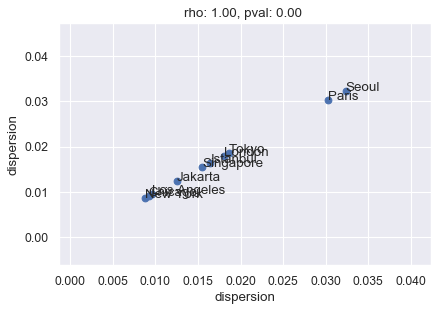

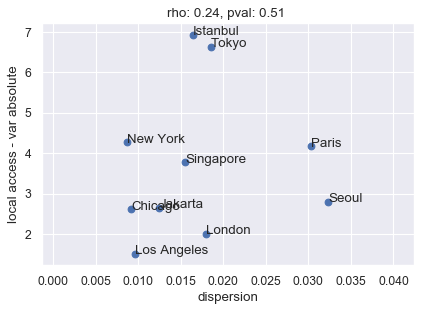

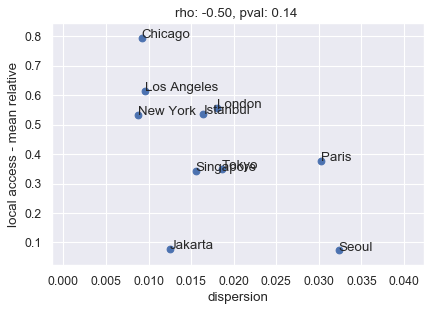

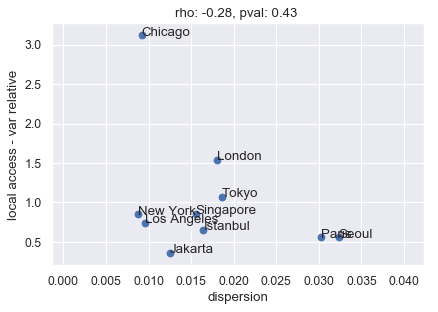

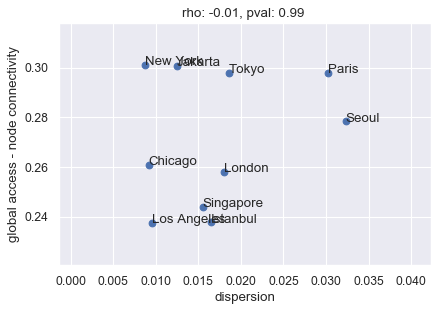

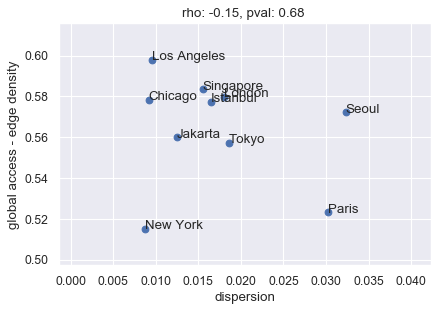

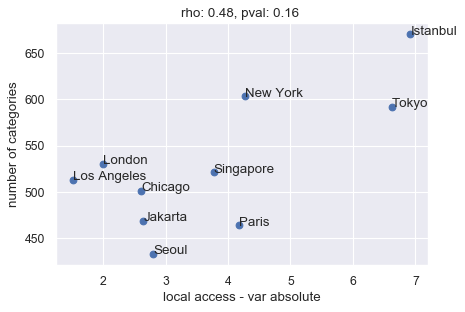

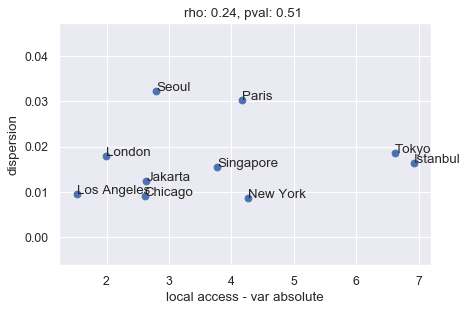

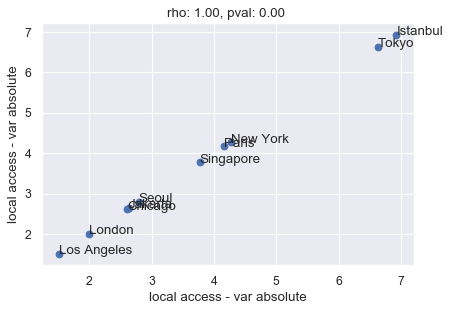

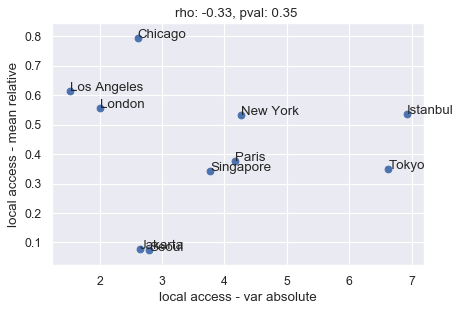

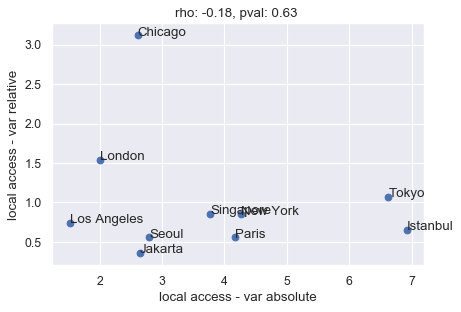

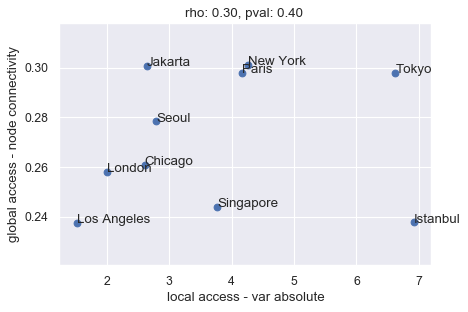

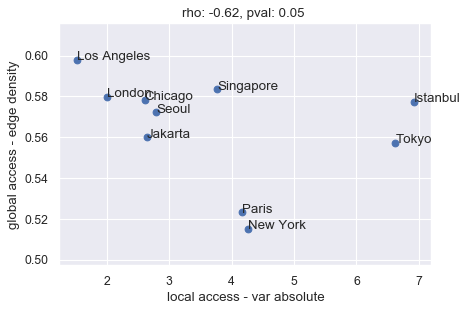

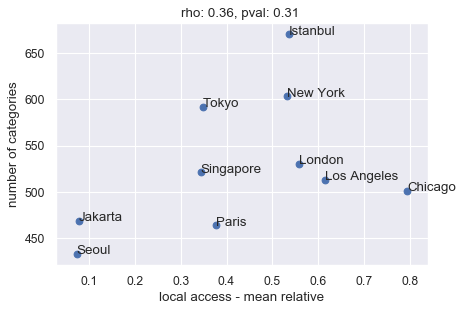

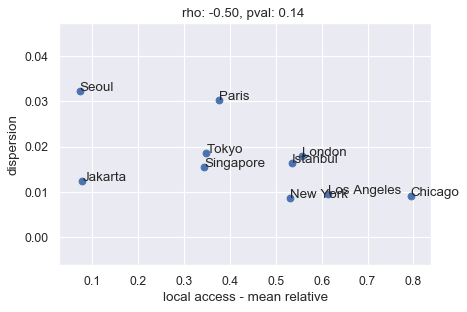

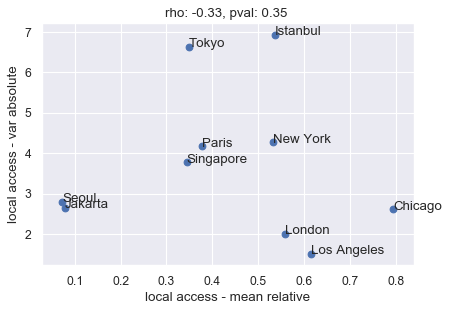

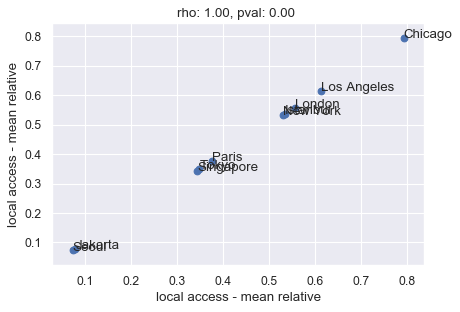

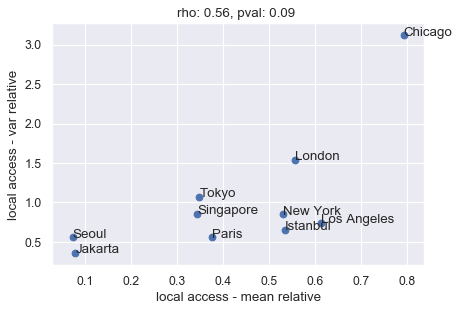

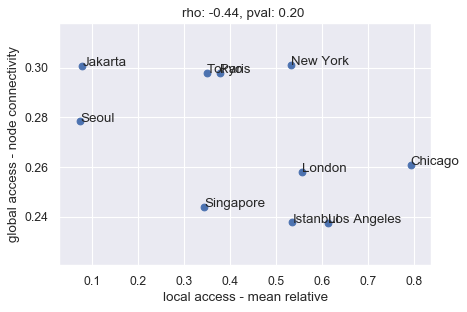

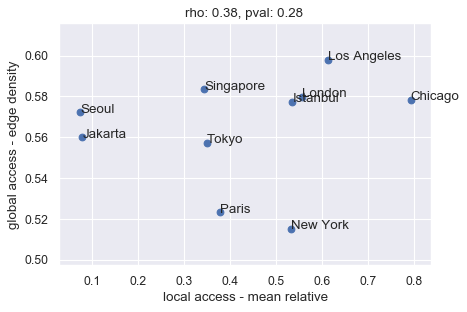

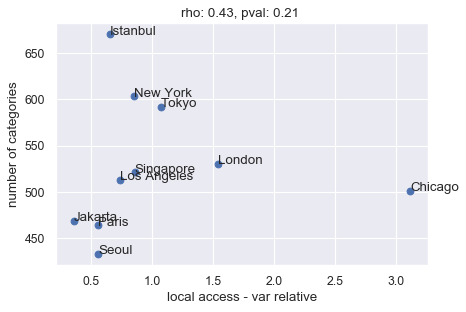

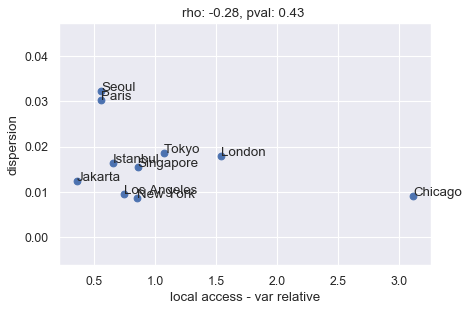

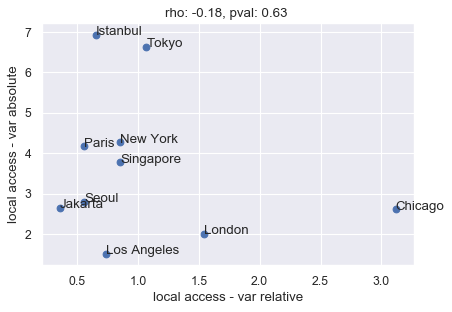

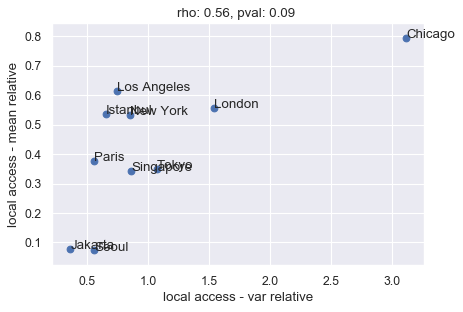

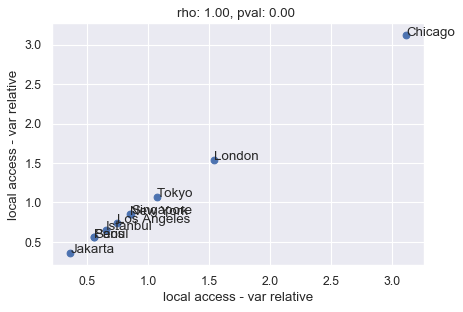

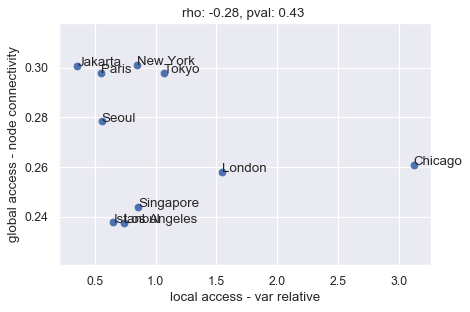

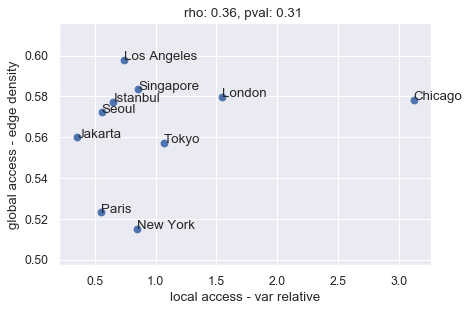

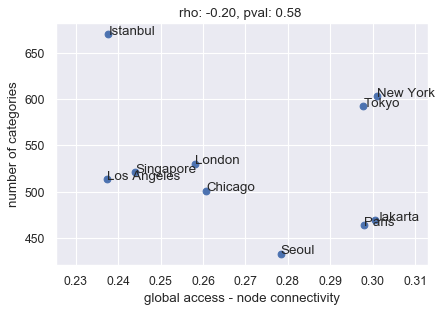

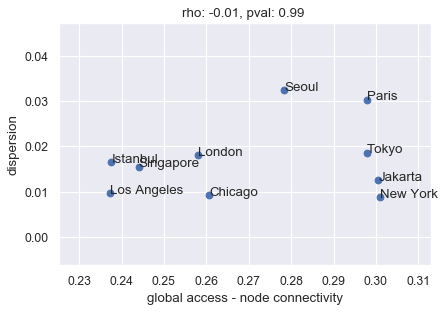

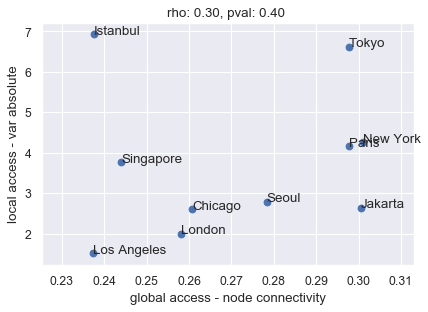

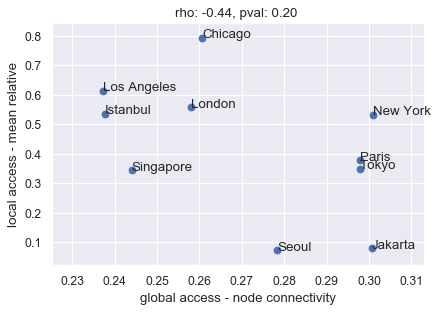

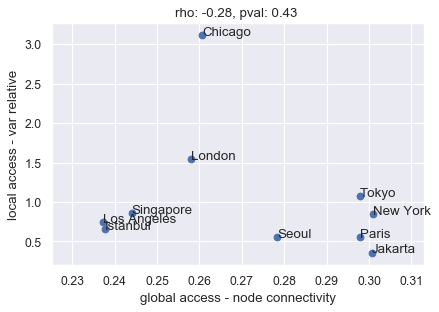

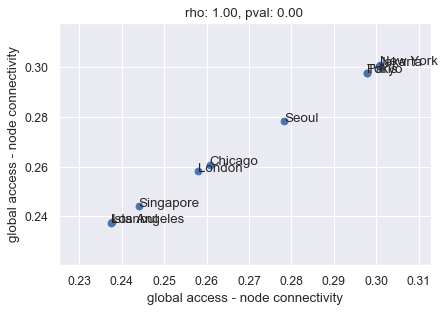

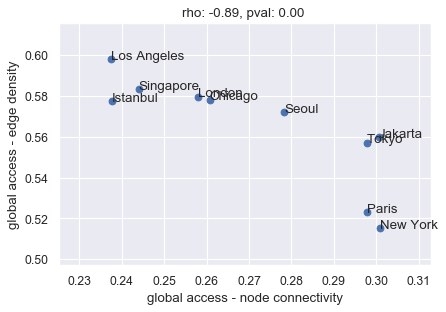

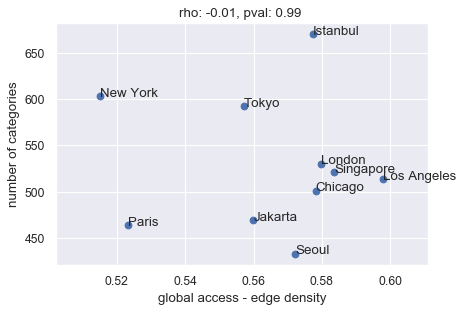

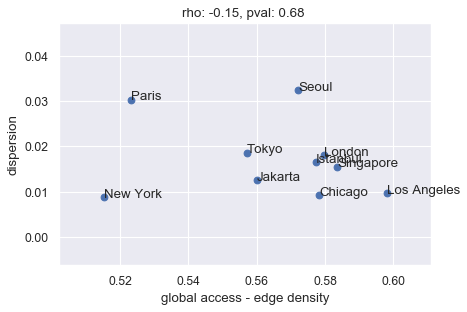

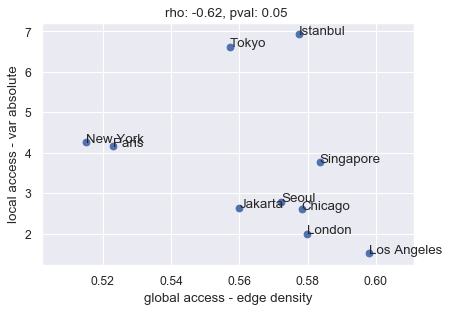

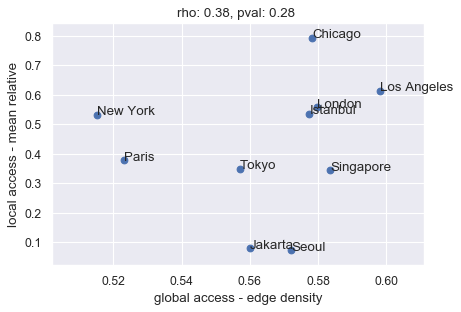

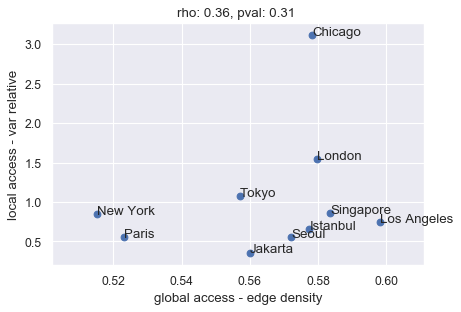

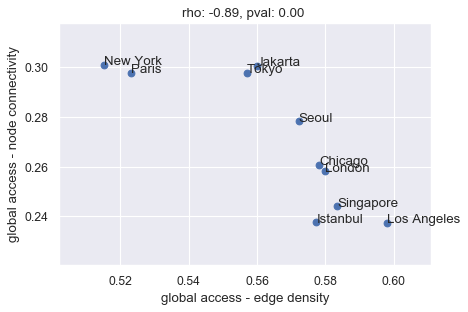

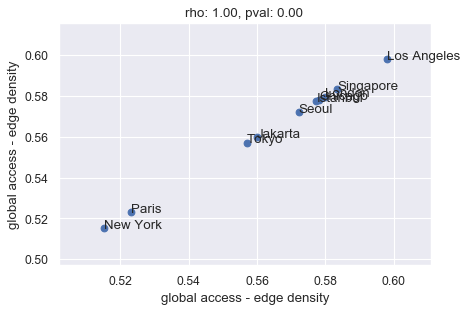

In [572]:
corrs_urban = pw({'number of categories':num,
                    'dispersion':dev,
                    'local access - var absolute':sas_var, 
                    'local access - mean relative':sas_lr_mean,
                    'local access - var relative':sas_lr_var, 
                    'global access - node connectivity':betti_0, 
                    'global access - edge density':betti_1})

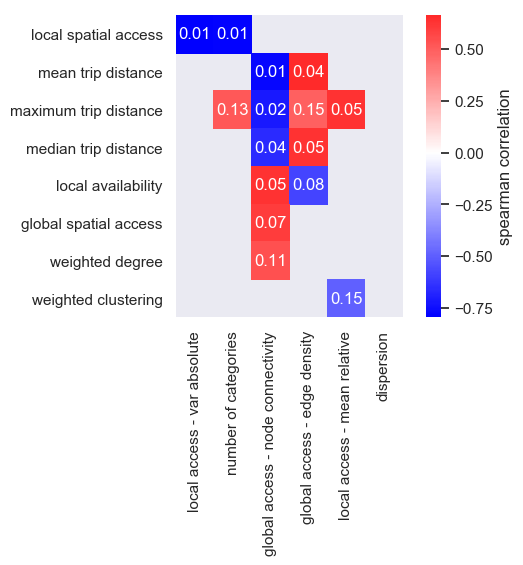

In [579]:
import seaborn as sns
sns.heatmap(corrs[0], annot=corrs[1], mask=corrs[1]>0.15, fmt='.2f', square=True, cmap='bwr', center=0, annot_kws={'fontsize':12}, cbar_kws={'label':'spearman correlation'})
sns.set(rc={'figure.dpi':100})

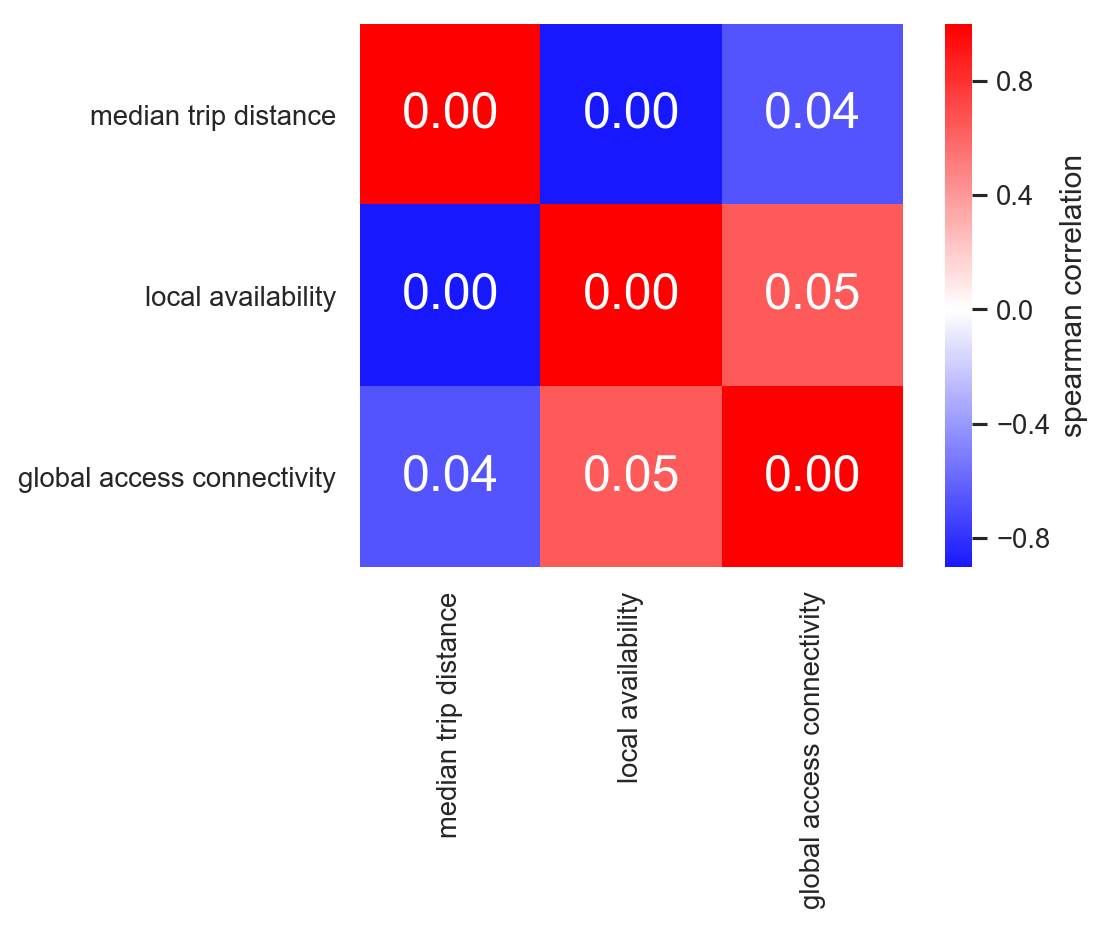

In [39]:
import seaborn as sns
sns.heatmap(corrs_int[0], annot=corrs_int[1], mask=corrs_int[1]>0.15, fmt='.2f', square=True, cmap='bwr', center=0, annot_kws={'fontsize':20}, cbar_kws={'label':'spearman correlation'})
sns.set(rc={'figure.dpi':180})

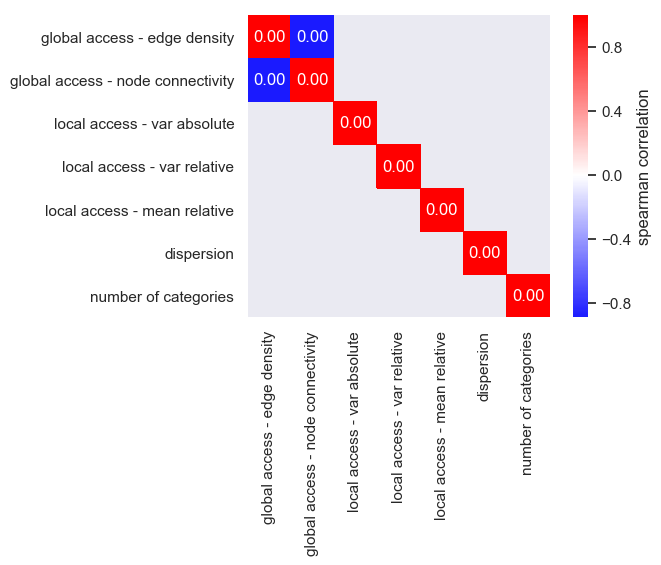

In [582]:
sns.heatmap(corrs_urban[0], annot=corrs_urban[1], mask=corrs_urban[1]>0.05, fmt='.2f', square=True, cmap='bwr', center=0, annot_kws={'fontsize':12}, cbar_kws={'label':'spearman correlation'})
sns.set(rc={'figure.dpi':100})

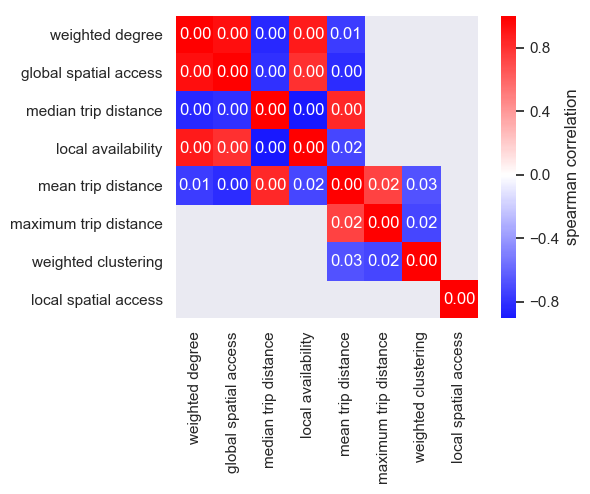

In [583]:
sns.heatmap(corrs_spatial[0], annot=corrs_spatial[1], mask=corrs_spatial[1]>0.05, fmt='.2f', square=True, cmap='bwr', center=0, annot_kws={'fontsize':12}, cbar_kws={'label':'spearman correlation'})
sns.set(rc={'figure.dpi':100})

In [230]:
#from pandas import DataFrame
#stats = DataFrame({'sas_mean':sas_mean, 'sas_var':sas_var, 'betti_0':betti_0, 'betti_1':betti_1}, index=betti.keys())
#stats.to_csv('4sq_stats.csv')

In [92]:
def solve_w(p, q, pi, w=1.):
    from math import sqrt
    a = pi
    b = w+p*(2*pi-1)
    c = pi*((p**2-q**2)*(1-pi)**2-w*p)
    d = b**2 - 4*a*c
    return (b + sqrt(d))/(2*a)

In [1193]:
def solve_rho(lambda1, lambda2, pi, w=1.):
    prod_e = (lambda1*lambda2)/w**2
    sum_e = (lambda1+lambda2)/w
    pi1 = pi
    pi2 = 1-pi
    rho1 = pi1*(1 + (prod_e*pi1-sum_e)*pi2)/(pi1-pi2)
    rho2 = pi2*(1 + (prod_e*pi2-sum_e)*pi1)/(pi2-pi1)
    return pi1, rho1, pi2, rho2

In [1296]:
def get_constraints(lambda1, lambda2, w=1.):
    from sympy import symbols, Number, solveset, S
    pi1 = symbols('pi')
    pi2 = 1-pi1 # pi constraint
    w = symbols('mom')
    w1 = symbols('omega')
    w2 = (w-pi1*w1)/pi2 # omega constraint
    lambda_sum = lambda1+lambda2
    lambda_prod = lambda1*lambda2
    rho1 = (1 + lambda_prod*pi1*pi2/(w1*w2) - lambda_sum*pi2/w2)/(1-w1*pi2/(w2*pi1)) # lambda constraint
    rho2 = (1 + lambda_prod*pi1*pi2/(w1*w2) - lambda_sum*pi1/w1)/(1-w2*pi1/(w1*pi2))
    constraints = [(pi1, Number(0), '>='), (pi1, Number(1), '<=')]
    constraints += [(w1, Number(0), '>='), (w1*pi1, Number(w), '<=')]
    constraints += [(rho1, Number(0), '>='), (rho1, Number(1), '<=')]
    constraints += [(rho2, Number(0), '>='), (rho2, Number(1), '<=')]
    solutions = []
    solutions.append(solveset(pi1>=0, pi1, domain=S.Reals))
    solutions.append(solveset(pi1<=1, pi1, domain=S.Reals))
    solutions.append(solveset(w1*pi1<=w, pi1, domain=S.Reals))
    solutions.append(solveset(lambda_sum - lambda_prod*pi1/w1 >= w1/pi1 , pi1, domain=S.Reals))
    solutions.append(solveset(lambda_sum - lambda_prod*pi1/w1 >= w2/pi2 , pi1, domain=S.Reals))
    solutions.append(solveset(lambda_sum - lambda_prod*pi2/w2 >= w1/pi1 , pi1, domain=S.Reals))
    solutions.append(solveset(lambda_sum - lambda_prod*pi2/w2 >= w2/pi2 , pi1, domain=S.Reals))
    intervals = solutions[0]
    for i in range(1, len(solutions)): intervals = intervals.intersect(solutions[i])
    return intervals

In [ ]:
def pi_given_omega(lambda1, lambda2, w, mo=1.):
    from math import sqrt
    assert(w>=0)
    assert(mo>0)
    a = w/mo
    if a<=1:
        pi_1 = (0, 1)
        pi_2 = (,)
    else:
        tmp = (1+1/a)/2
        tmp = tmp - sqrt(tmp**2-1)
        pi_1 = (0, tmp)
        pi_2 = (tmp, 1)
    lambda_sum = lambda1+lambda2
    lambda_prod = lambda1*lambda2
    tmp = lambda_sum**2-4*lambda_prod
    if lambda_prod>0:
        if tmp>=0:
            x = (max(0, (lambda_sum-sqrt(tmp))/(2*lambda_prod)), (lambda_sum+sqrt(tmp))/(2*lambda_prod))
            y = None
        else:
            x = (,)
            y = (,)
    else:
        x = (max(0, (lambda_sum-sqrt(tmp))/(2*lambda_prod)), float('inf'))
        y = None
    if pi_1:
        if x:
            
        else: pi_1 = (,)
       

In [1297]:
[get_constraints(p[i], q[i], w=mo) for i in range(len(p))]

KeyboardInterrupt: 

In [1200]:
params = [solve_rho(p_i, q_i, 0.2, w=mo) for (p_i, q_i) in zip(p, q)]
print(params)

[(0.2, 1.7960252186966108, 0.8, -0.1932786139989287), (0.2, 1.392099402479534, 0.8, 0.08940503962446418), (0.2, 1.3196192396878896, 0.8, -0.7633715338040488), (0.2, 1.11836385148466, 0.8, 0.28097627021958316), (0.2, 0.9349541636723823, 0.8, 0.40933380167490674), (0.2, 0.8643767990433462, 0.8, 0.45872670130012944), (0.2, -0.03094193739784501, 0.8, 1.0853070321761813)]


In [1187]:
def solve_k(p, q, pi, w=1.):
    from math import sqrt
    b = (p*(pi**2+(1-pi)**2)-w)/(q*pi*(1-pi))
    try: return (-b + sqrt(b**2-4))/2, (-b - sqrt(b**2-4))/2
    except: return

In [1180]:
def solve_params(p, q, pi): 
    rho1, rho2 = p*(1+pi)/(p*(1+pi)+q*(1-pi)), p*(1-pi)/(p*(1-pi)+q*(1+pi))
    w1, w2 = p*rho1/pi, p*rho2/(1-pi)
    return pi, 1-pi, rho1, rho2, w1, w2, w1*rho1/pi, w1*(1-rho1)*(1+1/pi)/(1-pi)

In [1160]:
def solve_params(p, q, pi, w=1.):
    from math import sqrt
    a = pi
    b = w+p*(2*pi-1)
    c = pi*((p**2-q**2)*(1-pi)**2-w*p)
    d = b**2 - 4*a*c
    w1 = (b + sqrt(d))/(2*a)
    w2 = (w-w1*pi)/(1-pi)
    rho1 = p*pi/w1
    rho2 = p*(1-pi)/w2
    return pi, 1-pi, rho1, rho2, w1, w2

In [1157]:
params = [solve_rho(p_i, q_i, 0.8) for (p_i, q_i) in zip(p, q)]
print(params)

[(0.9068112667374092, 0.10725022889672337), (0.8924160863384395, 0.09289504929586029), (0.9071149327240398, 0.10759528794870409), (0.9078640276848309, 0.10845505704174736), (0.9084256809123709, 0.10910780979353425), (0.9094659742229962, 0.11033563516572553), (0.9117252827965301, 0.11308953625686001), (0.8857262287432554, 0.08733334781741503), (0.9139877835305392, 0.11597391372950677), (0.9160647552510354, 0.11874091749801749), (0.9170382885613305, 0.1200793326901661), (0.9736812340088076, 0.31353432069096615)]


In [1192]:
params = [solve_k(p_i, q_i, 0.5, 1) for (p_i, q_i) in zip(p, q)]
print(params)

[(-0.6700919387094423, -1.4923325326461039), None, (-0.6638451797764593, -1.5063753273568037), (-0.6491166435924451, -1.5405551681214644), (-0.6386418636067517, -1.5658228139828885), (-0.6203465042168685, -1.612002313549602), (-0.5846000706194013, -1.710571124188319), None, (-0.5529685423297499, -1.8084211369182612), (-0.5266973516836119, -1.8986235582986222), (-0.5151294445583637, -1.9412596398121456), (-0.12349080075662666, -8.09776917691854)]


In [1181]:
params = [solve_params(p_i, q_i, 0.2) for (p_i, q_i) in zip(p, q)]
print([(a[-2], a[-1], p_i, q_i) for (a, p_i, q_i) in zip(params, p, q)])

[(219446908.5420541, 202963749.54737666, 22939830.59857655, 21216767.477845266), (170680041.67767346, 185184740.9950738, 20275669.20376454, 21998732.324495826), (210728307.22922984, 194199886.46468198, 21968110.556553252, 20245047.43582196), (192109350.58971435, 175468606.9818309, 19891931.81198691, 18168868.691255618), (180329113.73931444, 163603523.4846213, 18577427.80654234, 16854364.685811054), (162218817.87242466, 145334633.17516655, 16554738.506857883, 14831675.386126596), (134016029.33400977, 116780839.38304704, 13398058.181504201, 11674995.060772913), (84926787.57082477, 98613020.40459901, 10692074.101234943, 12415137.221966231), (114975230.817942, 97379277.4689504, 11258814.801945183, 9535751.681213897), (102274411.13772036, 84338851.73590717, 9825468.059172986, 8102404.9384417), (97405230.30636148, 79307638.94028793, 9273905.942083517, 7550842.8213522285), (42145728.29027781, 10252854.522521786, 2276989.8580528093, 553926.7373215227)]


In [948]:
params_re = [((p[4]*p[2]/p[0], p[4]*(1-p[2])/(1-p[0])), (p[5]*p[3]/p[1], p[5]*(1-p[3])/(1-p[1]))) for p in params]
print(params_re)

[((44334396.613462254, 44541090.39803774), (44334396.613462254, 44541090.39803774)), ((35880652.84286925, 36124870.636230886), (35880652.842869245, 36124870.63623087)), ((28633895.583932113, 28840636.16387474), (28633895.583932117, 28840636.163874745)), ((30151654.80386023, 30428258.811625678), (30151654.803860236, 30428258.81162568)), ((26313082.364171986, 26614530.9380246), (26313082.364171986, 26614530.938024603)), ((24835972.13099754, 25147365.424922768), (24835972.130997535, 25147365.424922764)), ((6097889.822296294, 1332416.5157817523), (6097889.822296294, 1332416.5157817514))]


In [909]:
params_re = [p[4]*p[0] + p[5]*p[1] for p in params]
print(params_re)

[10146880.0000000, 10146880.0000000, 10146880.0000000, 10146880.0000000, 10146880.0000000, 10146880.0000000, 10146880.0000000, 10146880.0000000, 10146880.0000000]


In [904]:
print([(a[0]+a[1], a[0]-a[1]) for a in params_re])

[(35971896.2907194, -22773195.5262213), (33981328.9802141, -20513599.5598714), (30970307.7358861, -16984694.1501919), (26473057.0074428, -11275504.4722004), (26995316.5785689, -13146333.8685680), (23677956.3031750, -7153826.21314943), (22011400.3841575, -4185966.66907421), (21435140.4495128, -2978870.26151810), (19815622.4774450, 18024620.6491658)]


In [259]:
m = 4
a = np.ones((m, m)) - np.eye(m)
a = np.vstack([np.ones(m), a])
ata = np.dot(a.transpose(), a)
print(np.linalg.matrix_rank(ata))
a_inv = np.linalg.inv(ata)

4


In [262]:
a_inv

array([[ 0.76923077, -0.23076923, -0.23076923, -0.23076923],
       [-0.23076923,  0.76923077, -0.23076923, -0.23076923],
       [-0.23076923, -0.23076923,  0.76923077, -0.23076923],
       [-0.23076923, -0.23076923, -0.23076923,  0.76923077]])

In [204]:
from itertools import product
m = 4
a = np.hstack([np.array(list(product(*[[1, 0]]*m))), np.array(list(product(*[[0, 1]]*m)))])
print(np.linalg.matrix_rank(a))
#ata_inv = np.linalg.inv(np.matmul(a, a.transpose()))
print(a)
#print(ata_inv)

5
[[1 1 1 1 0 0 0 0]
 [1 1 1 0 0 0 0 1]
 [1 1 0 1 0 0 1 0]
 [1 1 0 0 0 0 1 1]
 [1 0 1 1 0 1 0 0]
 [1 0 1 0 0 1 0 1]
 [1 0 0 1 0 1 1 0]
 [1 0 0 0 0 1 1 1]
 [0 1 1 1 1 0 0 0]
 [0 1 1 0 1 0 0 1]
 [0 1 0 1 1 0 1 0]
 [0 1 0 0 1 0 1 1]
 [0 0 1 1 1 1 0 0]
 [0 0 1 0 1 1 0 1]
 [0 0 0 1 1 1 1 0]
 [0 0 0 0 1 1 1 1]]


In [165]:
np.allclose(np.eye(m), np.dot(a_inv, a))

True

In [185]:
2**np.dot(a_inv, eigs[-(m+1):-1][::-1])

array([ 0.945459  ,  5.61906703,  5.98748436,  6.94489199,  7.71726051,
        8.37380509, 10.4823178 , 11.83337831, 12.71140463, 14.09819354])

In [183]:
psi = [2*np.eye(2) + ((i-0.5)/2)*np.ones((2,2)) for i in 2**np.dot(a_inv, eigs[-m:][::-1])]

In [184]:
print(psi)

[array([[2.16052201, 0.16052201],
       [0.16052201, 2.16052201]]), array([[2.42446953, 0.42446953],
       [0.42446953, 2.42446953]]), array([[5.75851807, 3.75851807],
       [3.75851807, 5.75851807]]), array([[6.02133884, 4.02133884],
       [4.02133884, 6.02133884]]), array([[6.70433226, 4.70433226],
       [4.70433226, 6.70433226]]), array([[7.25532287, 5.25532287],
       [5.25532287, 7.25532287]]), array([[7.72368724, 5.72368724],
       [5.72368724, 7.72368724]]), array([[9.22785355, 7.22785355],
       [7.22785355, 9.22785355]]), array([[10.19167021,  8.19167021],
       [ 8.19167021, 10.19167021]]), array([[10.81803476,  8.81803476],
       [ 8.81803476, 10.81803476]])]


In [143]:
a = [np.hstack([np.array([1]*(m-i) + [0]*(m-i))]*(i+1)) for i in range(m)]

In [149]:
a = np.kron(np.eye(m), np.ones((2,2)))

In [150]:
print(a)

[[1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1.]]


In [135]:
a = np.vstack([[0]*i + [1]*m + [0]*(m-i) for i in range(m+1)])
b = np.vstack([1]*(i+1) + [0] + [1]*(m-1-(i+1)) + [0]*(i+1) + [1] + [0]*(m-1-(i+1)) for i in range(m-1))
c = np.vstack([a, b])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [137]:
print(a)
print(np.linalg.matrix_rank(a))
#print(np.allclose(np.eye(2*m), np.dot(a, a_inv)))

[[1 1 1 1 0 0 0 0]
 [0 1 1 1 1 0 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 0]
 [0 0 0 0 1 1 1 1]]
5


In [136]:
print(b)
print(np.linalg.matrix_rank(b))

[[1 0 1 1 0 1 0 0]
 [1 1 0 1 0 0 1 0]
 [1 1 1 0 0 0 0 1]]
3


In [138]:
print(c)
print(np.linalg.matrix_rank(c))

[[1 1 1 1 0 0 0 0]
 [0 1 1 1 1 0 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 0]
 [0 0 0 0 1 1 1 1]
 [1 0 1 1 0 1 0 0]
 [1 1 0 1 0 0 1 0]
 [1 1 1 0 0 0 0 1]]
5


In [91]:
np.dot(a_inv, eigs)

array([-1.50275340e+16,  2.29212781e+16,  2.69359973e+16, -3.59768312e+16,
       -1.44184554e+16,  2.43623617e+16, -1.96713070e+15,  1.98554925e+15,
       -8.77382533e+15, -4.14097599e+13, -1.50275340e+16,  2.29212781e+16,
        2.69359973e+16, -3.59768312e+16, -1.44184554e+16,  2.43623617e+16,
       -1.96713070e+15,  1.98554925e+15, -8.77382533e+15, -4.14097599e+13])

In [ ]:
m = 10
np.ones((m,m))

In [22]:
print(lon_sbm.mean_affinity(), lon_sbm.mean_homoffinity(), lon_sbm.mean_heteroffinity())
print(lon_com.mean_affinity(), lon_com.mean_homoffinity(), lon_com.mean_heteroffinity())
print(lon_sbm.sas_global(), lon_com.sas_global())

10146880.0 897522.0 9249358.0
10146880.000000006 1732698.9999999995 8414181.000000007
(2.6486815325287636, 2.9635687513654543) (2.2897691967896288, 2.7159970987784643)


C:\Users\sl2416\Documents\phd\dat\egosbm.py:1169: RuntimeWarning: divide by zero encountered in log2
  if log_ratio: out = np.log2(out) - np.hstack([np.log2(np.diag(out))[:,np.newaxis]]*self.get_shape())
C:\Users\sl2416\Documents\phd\dat\egosbm.py:1169: RuntimeWarning: invalid value encountered in subtract
  if log_ratio: out = np.log2(out) - np.hstack([np.log2(np.diag(out))[:,np.newaxis]]*self.get_shape())
